In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(1))
print(torch.cuda.current_device())

True
NVIDIA GeForce RTX 3090
0


In [3]:
print('Hello, World!')

Hello, World!


In [7]:
! pip install split-folders[full]

  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)


In [10]:
! pip install torchvision

In [12]:
! pip install transformers accelerate torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 240.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 351.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 820.1 kB/s eta 0:00:0000:0100:01
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
  Using cached tokenizers-0.13.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached filelock-3.9.0-py3-none-any.whl (9.7 kB)
  Using cached huggingface_hub-0.12.1-py3-none-any.whl (190 kB)
  Using cached regex-2022.10.31-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (772 kB)


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import splitfolders
import torch.nn.functional as F
import cv2
from PIL import Image

In [61]:
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

In [65]:
dilation_kernel = np.ones((3, 3), dtype=np.uint8)
erosion_kernel = Image.fromarray(np.ones((3, 3), dtype=np.uint8))
class Dilation(object):
    def __init__(self, kernel):
        self.kernel = kernel
    
    def __call__(self, image):
        image = np.array(image)  # Convert PIL image to NumPy array
        image = image.astype(np.uint8)  # Convert to 8-bit unsigned integer
        dilated_image = cv2.dilate(image, self.kernel, iterations=1)
        return torch.from_numpy(dilated_image).float()

In [66]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((320,240)),
#         transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.RandomApply(transforms=[transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.25),
        transforms.RandomPerspective(distortion_scale=0.6, p=0.25),
        transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=.5, hue=.3),
                                           # transforms.RandomInvert(),
                                           transforms.RandomAffine(30,translate=(0.1,0.1),
                                                                   shear=(-15,15))], p=0.25),
        transforms.Grayscale(num_output_channels=3),
#         transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.25),
#         transforms.RandomRotation(30),
        transforms.ToTensor(),
        ThresholdTransform(thr_255=90),
        Dilation(kernel=dilation_kernel),
#         cv2.dilate()
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((320,240)),
        transforms.Grayscale(num_output_channels=3),
        # transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        ThresholdTransform(thr_255=90),
        Dilation(kernel=dilation_kernel),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = "/home/dlpc01/Rifat/CSE 4836 Pattern Recognition Lab/data2"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #SELECT GPU FROM HERE

torch.Size([3, 320, 240])
torch.Size([3, 320, 240])
torch.Size([3, 320, 240])
torch.Size([3, 320, 240])
torch.Size([3, 320, 240])
torch.Size([3, 320, 240])
torch.Size([3, 320, 240])
torch.Size([3, 320, 240])


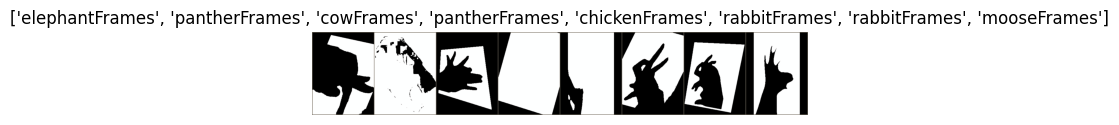

In [68]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
for i in inputs:
    print(i.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [34]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [35]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5103 Acc: 0.8566
val Loss: 1.0422 Acc: 0.6920

Epoch 1/24
----------
train Loss: 0.0991 Acc: 0.9763
val Loss: 0.8113 Acc: 0.7996

Epoch 2/24
----------
train Loss: 0.0504 Acc: 0.9887
val Loss: 0.6914 Acc: 0.8167

Epoch 3/24
----------
train Loss: 0.0360 Acc: 0.9935
val Loss: 0.8671 Acc: 0.8121

Epoch 4/24
----------
train Loss: 0.0294 Acc: 0.9954
val Loss: 0.5197 Acc: 0.8534

Epoch 5/24
----------
train Loss: 0.0180 Acc: 0.9965
val Loss: 0.5819 Acc: 0.8424

Epoch 6/24
----------
train Loss: 0.0201 Acc: 0.9963
val Loss: 0.5408 Acc: 0.8520

Epoch 7/24
----------
train Loss: 0.0173 Acc: 0.9954
val Loss: 0.5541 Acc: 0.8507

Epoch 8/24
----------
train Loss: 0.0120 Acc: 0.9983
val Loss: 0.6750 Acc: 0.8330

Epoch 9/24
----------
train Loss: 0.0183 Acc: 0.9954
val Loss: 0.5832 Acc: 0.8440

Epoch 10/24
----------
train Loss: 0.0147 Acc: 0.9972
val Loss: 0.6691 Acc: 0.8405

Epoch 11/24
----------
train Loss: 0.0154 Acc: 0.9972
val Loss: 0.5915 Acc: 0.8523

Ep

In [229]:
torch.cuda.empty_cache()

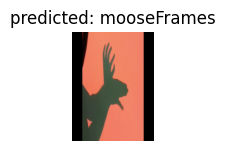

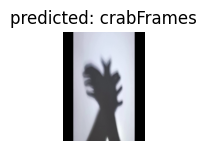

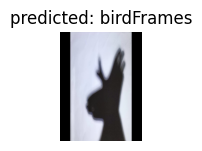

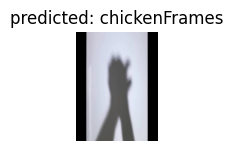

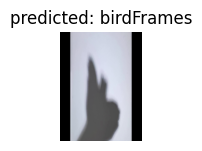

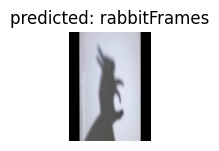

In [36]:
visualize_model(model_ft)

In [37]:
def train_model2(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [38]:
model_ft2 = models.vit_b_16(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs2 = model_ft2.heads.head.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft2.fc = nn.Linear(num_ftrs2, 11)

model_ft2 = model_ft2.to(device)

criterion2 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft2 = optim.SGD(model_ft2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer_ft2, step_size=5, gamma=0.1)

In [39]:
model_ft2 = train_model2(model_ft2, criterion2, optimizer_ft2, exp_lr_scheduler2, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.0599 Acc: 0.3194
val Loss: 2.1546 Acc: 0.3080

Epoch 1/24
----------
train Loss: 1.2448 Acc: 0.5814
val Loss: 2.2376 Acc: 0.3722

Epoch 2/24
----------
train Loss: 0.9737 Acc: 0.6635
val Loss: 2.1971 Acc: 0.3420

Epoch 3/24
----------
train Loss: 0.7991 Acc: 0.7363
val Loss: 1.8894 Acc: 0.3958

Epoch 4/24
----------
train Loss: 0.7037 Acc: 0.7554
val Loss: 2.1103 Acc: 0.4691

Epoch 5/24
----------
train Loss: 0.4939 Acc: 0.8384
val Loss: 1.9111 Acc: 0.5050

Epoch 6/24
----------
train Loss: 0.4308 Acc: 0.8538
val Loss: 1.8844 Acc: 0.5186

Epoch 7/24
----------
train Loss: 0.3721 Acc: 0.8803
val Loss: 1.9048 Acc: 0.5082

Epoch 8/24
----------
train Loss: 0.3673 Acc: 0.8844
val Loss: 1.9045 Acc: 0.5170

Epoch 9/24
----------
train Loss: 0.3414 Acc: 0.8851
val Loss: 1.8920 Acc: 0.5432

Epoch 10/24
----------
train Loss: 0.3259 Acc: 0.8944
val Loss: 1.8919 Acc: 0.5454

Epoch 11/24
----------
train Loss: 0.3136 Acc: 0.9020
val Loss: 1.8833 Acc: 0.5405

Ep

In [40]:
def visualize_model2(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

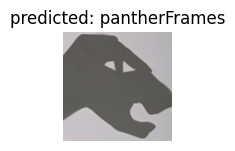

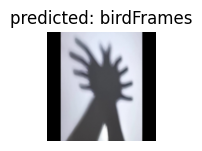

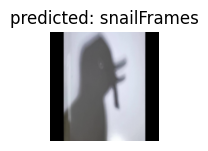

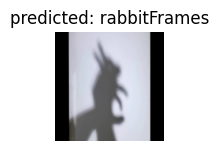

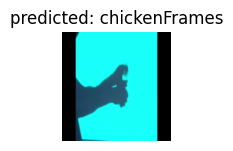

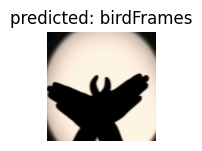

In [41]:
visualize_model2(model_ft2)

In [42]:
def train_model3(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [43]:
model_ft3 = models.googlenet(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs3 = model_ft3.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft3.fc = nn.Linear(num_ftrs3, 11)

model_ft3 = model_ft3.to(device)

criterion3 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft3 = optim.SGD(model_ft3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler3 = lr_scheduler.StepLR(optimizer_ft3, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
model_ft3 = train_model3(model_ft3, criterion3, optimizer_ft3, exp_lr_scheduler3, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9384 Acc: 0.7691
val Loss: 1.0520 Acc: 0.6489

Epoch 1/24
----------
train Loss: 0.1737 Acc: 0.9663
val Loss: 0.8570 Acc: 0.7332

Epoch 2/24
----------
train Loss: 0.0950 Acc: 0.9813
val Loss: 0.6571 Acc: 0.8100

Epoch 3/24
----------
train Loss: 0.0646 Acc: 0.9870
val Loss: 0.6849 Acc: 0.8108

Epoch 4/24
----------
train Loss: 0.0486 Acc: 0.9894
val Loss: 0.8347 Acc: 0.7918

Epoch 5/24
----------
train Loss: 0.0429 Acc: 0.9907
val Loss: 0.8151 Acc: 0.7980

Epoch 6/24
----------
train Loss: 0.0280 Acc: 0.9941
val Loss: 0.8601 Acc: 0.8044

Epoch 7/24
----------
train Loss: 0.0328 Acc: 0.9930
val Loss: 0.7987 Acc: 0.8049

Epoch 8/24
----------
train Loss: 0.0253 Acc: 0.9963
val Loss: 0.7945 Acc: 0.8089

Epoch 9/24
----------
train Loss: 0.0315 Acc: 0.9948
val Loss: 0.7599 Acc: 0.8103

Epoch 10/24
----------
train Loss: 0.0315 Acc: 0.9946
val Loss: 0.7585 Acc: 0.8079

Epoch 11/24
----------
train Loss: 0.0268 Acc: 0.9952
val Loss: 0.8302 Acc: 0.8044

Ep

In [45]:
def visualize_model3(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

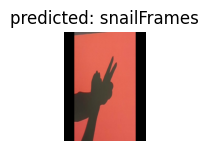

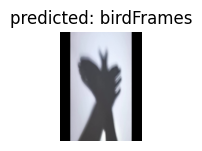

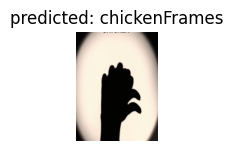

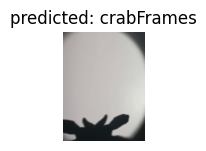

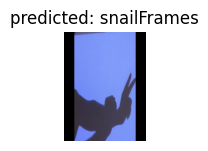

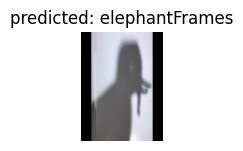

In [46]:
visualize_model3(model_ft3)

In [47]:
def train_model4(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [48]:
model_ft4 = models.maxvit_t(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs4 = model_ft4.classifier[3].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft4.fc = nn.Linear(num_ftrs4, 11)

model_ft4 = model_ft4.to(device)

criterion4 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft4 = optim.SGD(model_ft4.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler4 = lr_scheduler.StepLR(optimizer_ft4, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaxVit_T_Weights.IMAGENET1K_V1`. You can also use `weights=MaxVit_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [49]:
model_ft4 = train_model4(model_ft4, criterion4, optimizer_ft4, exp_lr_scheduler4, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9587 Acc: 0.7575
val Loss: 1.0620 Acc: 0.6805

Epoch 1/24
----------
train Loss: 0.1182 Acc: 0.9707
val Loss: 1.2508 Acc: 0.7022

Epoch 2/24
----------
train Loss: 0.0724 Acc: 0.9800
val Loss: 1.0546 Acc: 0.7337

Epoch 3/24
----------
train Loss: 0.0411 Acc: 0.9878
val Loss: 0.6964 Acc: 0.8210

Epoch 4/24
----------
train Loss: 0.0388 Acc: 0.9902
val Loss: 0.5100 Acc: 0.8657

Epoch 5/24
----------
train Loss: 0.0247 Acc: 0.9933
val Loss: 0.7427 Acc: 0.8199

Epoch 6/24
----------
train Loss: 0.0235 Acc: 0.9930
val Loss: 0.7490 Acc: 0.8234

Epoch 7/24
----------
train Loss: 0.0202 Acc: 0.9950
val Loss: 0.7202 Acc: 0.8237

Epoch 8/24
----------
train Loss: 0.0211 Acc: 0.9939
val Loss: 0.6305 Acc: 0.8405

Epoch 9/24
----------
train Loss: 0.0184 Acc: 0.9950
val Loss: 0.6326 Acc: 0.8368

Epoch 10/24
----------
train Loss: 0.0201 Acc: 0.9954
val Loss: 0.5417 Acc: 0.8766

Epoch 11/24
----------
train Loss: 0.0171 Acc: 0.9961
val Loss: 0.7398 Acc: 0.8188

Ep

In [50]:
print(model_ft4.classifier[3])

Linear(in_features=512, out_features=512, bias=True)


In [51]:
print(model_ft2)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [52]:
def visualize_model4(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

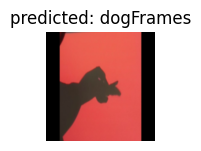

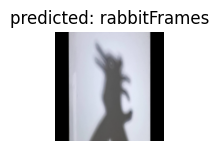

IndexError: list index out of range

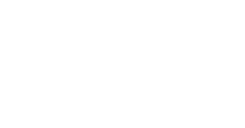

In [53]:
visualize_model4(model_ft4)

In [55]:
def train_model5(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [56]:
model_ft5 = models.vgg16(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs5 = model_ft5.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft5.fc = nn.Linear(num_ftrs5, 11)

model_ft5 = model_ft5.to(device)

criterion5 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft5 = optim.SGD(model_ft5.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler5 = lr_scheduler.StepLR(optimizer_ft5, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
model_ft5 = train_model5(model_ft5, criterion5, optimizer_ft5, exp_lr_scheduler5, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6571 Acc: 0.8247
val Loss: 1.6387 Acc: 0.6246

Epoch 1/24
----------
train Loss: 0.1231 Acc: 0.9629
val Loss: 1.0294 Acc: 0.7774

Epoch 2/24
----------
train Loss: 0.0634 Acc: 0.9807
val Loss: 1.4090 Acc: 0.7271

Epoch 3/24
----------
train Loss: 0.0510 Acc: 0.9850
val Loss: 0.9906 Acc: 0.8041

Epoch 4/24
----------
train Loss: 0.0374 Acc: 0.9907
val Loss: 1.1417 Acc: 0.7707

Epoch 5/24
----------
train Loss: 0.0209 Acc: 0.9944
val Loss: 0.9829 Acc: 0.8057

Epoch 6/24
----------
train Loss: 0.0118 Acc: 0.9972
val Loss: 0.9632 Acc: 0.8113

Epoch 7/24
----------
train Loss: 0.0095 Acc: 0.9970
val Loss: 0.9589 Acc: 0.8121

Epoch 8/24
----------
train Loss: 0.0140 Acc: 0.9954
val Loss: 0.9719 Acc: 0.8140

Epoch 9/24
----------
train Loss: 0.0058 Acc: 0.9985
val Loss: 1.0065 Acc: 0.8164

Epoch 10/24
----------
train Loss: 0.0077 Acc: 0.9983
val Loss: 1.0048 Acc: 0.8178

Epoch 11/24
----------
train Loss: 0.0123 Acc: 0.9954
val Loss: 1.0036 Acc: 0.8172

Ep

In [58]:
print(model_ft5)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [59]:
def visualize_model5(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

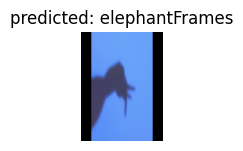

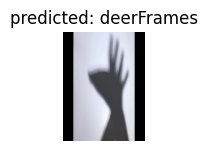

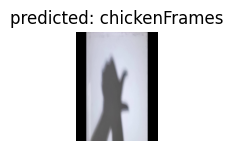

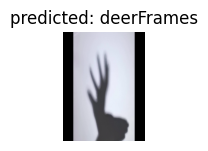

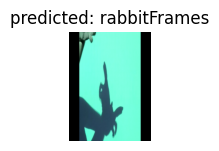

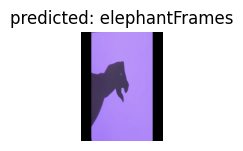

In [60]:
visualize_model5(model_ft5)

In [61]:
def train_model6(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [62]:
model_ft6 = models.swin_v2_b(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs6 = model_ft6.head.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft6.fc = nn.Linear(num_ftrs6, 11)

model_ft6 = model_ft6.to(device)

criterion6 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft6 = optim.SGD(model_ft6.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler6 = lr_scheduler.StepLR(optimizer_ft6, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
print(model_ft6)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

In [64]:
model_ft6 = train_model6(model_ft6, criterion6, optimizer_ft6, exp_lr_scheduler6, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2498 Acc: 0.6361
val Loss: 1.1412 Acc: 0.6821

Epoch 1/24
----------
train Loss: 0.1560 Acc: 0.9507
val Loss: 0.9635 Acc: 0.7391

Epoch 2/24
----------
train Loss: 0.0766 Acc: 0.9765
val Loss: 0.9210 Acc: 0.7725

Epoch 3/24
----------
train Loss: 0.0486 Acc: 0.9846
val Loss: 0.9828 Acc: 0.7972

Epoch 4/24
----------
train Loss: 0.0325 Acc: 0.9883
val Loss: 0.8723 Acc: 0.8282

Epoch 5/24
----------
train Loss: 0.0212 Acc: 0.9924
val Loss: 0.8695 Acc: 0.8247

Epoch 6/24
----------
train Loss: 0.0151 Acc: 0.9963
val Loss: 0.8638 Acc: 0.8282

Epoch 7/24
----------
train Loss: 0.0126 Acc: 0.9961
val Loss: 0.8739 Acc: 0.8274

Epoch 8/24
----------
train Loss: 0.0179 Acc: 0.9948
val Loss: 0.8614 Acc: 0.8309

Epoch 9/24
----------
train Loss: 0.0131 Acc: 0.9957
val Loss: 0.8716 Acc: 0.8306

Epoch 10/24
----------
train Loss: 0.0154 Acc: 0.9957
val Loss: 0.8650 Acc: 0.8303

Epoch 11/24
----------
train Loss: 0.0112 Acc: 0.9963
val Loss: 0.8642 Acc: 0.8309

Ep

In [65]:
def visualize_model6(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

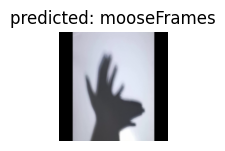

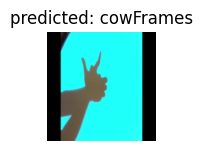

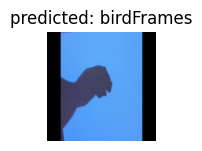

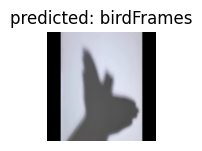

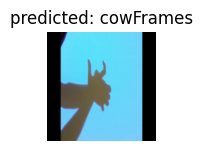

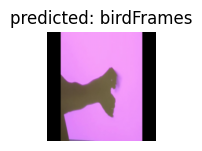

In [66]:
visualize_model6(model_ft6)

In [67]:
def train_model7(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [68]:
model_ft7 = models.convnext_large(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs7 = model_ft7.classifier[2].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft7.fc = nn.Linear(num_ftrs7, 11)

model_ft7 = model_ft7.to(device)

criterion7 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft7 = optim.SGD(model_ft7.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler7 = lr_scheduler.StepLR(optimizer_ft7, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
print(model_ft7)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [70]:
model_ft7 = train_model7(model_ft7, criterion7, optimizer_ft7, exp_lr_scheduler7, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5936 Acc: 0.5103
val Loss: 1.3155 Acc: 0.5951

Epoch 1/24
----------
train Loss: 0.1372 Acc: 0.9672
val Loss: 1.1464 Acc: 0.6888

Epoch 2/24
----------
train Loss: 0.0627 Acc: 0.9846
val Loss: 0.9491 Acc: 0.7822

Epoch 3/24
----------
train Loss: 0.0386 Acc: 0.9920
val Loss: 0.7157 Acc: 0.8303

Epoch 4/24
----------
train Loss: 0.0316 Acc: 0.9920
val Loss: 0.7536 Acc: 0.8194

Epoch 5/24
----------
train Loss: 0.0151 Acc: 0.9974
val Loss: 0.7418 Acc: 0.8360

Epoch 6/24
----------
train Loss: 0.0140 Acc: 0.9978
val Loss: 0.7313 Acc: 0.8373

Epoch 7/24
----------
train Loss: 0.0140 Acc: 0.9967
val Loss: 0.7674 Acc: 0.8354

Epoch 8/24
----------
train Loss: 0.0132 Acc: 0.9967
val Loss: 0.7735 Acc: 0.8333

Epoch 9/24
----------
train Loss: 0.0118 Acc: 0.9978
val Loss: 0.7050 Acc: 0.8448

Epoch 10/24
----------
train Loss: 0.0111 Acc: 0.9980
val Loss: 0.7095 Acc: 0.8437

Epoch 11/24
----------
train Loss: 0.0108 Acc: 0.9983
val Loss: 0.7105 Acc: 0.8435

Ep

In [71]:
def visualize_model7(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

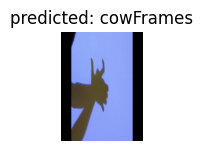

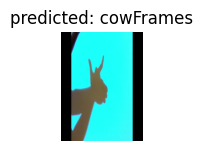

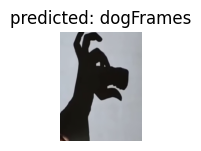

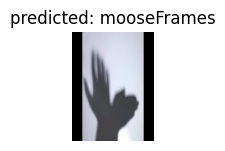

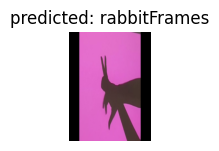

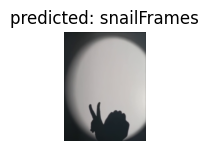

In [72]:
visualize_model7(model_ft7)

In [73]:
def train_model8(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(299,299), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
#                     outputs, aux_logits, __ = model(inputs)
                    outputs = model(inputs)
#                     print(outputs.logits)
#                     break
#                     print(len(outputs),outputs)
                    if len(outputs) == 2:
                        _, preds = torch.max(outputs[0], 1)
                        loss = criterion(outputs[0], labels)
                    else:
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
#                     loss1 = criterion(outputs[0], labels)
#                     loss2 = criterion(outputs[1], labels)
#                     loss = loss1 + 0.4*loss2

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [74]:
def visualize_model8(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = F.interpolate(inputs, size=(299,299), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if len(outputs) == 2:
                _, preds = torch.max(outputs[0], 1)
            else:
                _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [75]:
model_ft8 = models.inception_v3(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs8 = model_ft8.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft8.fc = nn.Linear(num_ftrs8, 11)

model_ft8 = model_ft8.to(device)

criterion8 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft8 = optim.SGD(model_ft8.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler8 = lr_scheduler.StepLR(optimizer_ft8, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
model_ft8 = train_model8(model_ft8, criterion8, optimizer_ft8, exp_lr_scheduler8, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6283 Acc: 0.8373
val Loss: 0.8019 Acc: 0.7843

Epoch 1/24
----------
train Loss: 0.1067 Acc: 0.9744
val Loss: 0.8535 Acc: 0.7897

Epoch 2/24
----------
train Loss: 0.0576 Acc: 0.9883
val Loss: 0.5777 Acc: 0.8630

Epoch 3/24
----------
train Loss: 0.0514 Acc: 0.9891
val Loss: 0.6458 Acc: 0.8373

Epoch 4/24
----------
train Loss: 0.0312 Acc: 0.9941
val Loss: 0.6962 Acc: 0.8472

Epoch 5/24
----------
train Loss: 0.0181 Acc: 0.9957
val Loss: 0.7630 Acc: 0.8469

Epoch 6/24
----------
train Loss: 0.0224 Acc: 0.9946
val Loss: 0.7125 Acc: 0.8630

Epoch 7/24
----------
train Loss: 0.0188 Acc: 0.9965
val Loss: 0.7769 Acc: 0.8571

Epoch 8/24
----------
train Loss: 0.0162 Acc: 0.9972
val Loss: 0.6889 Acc: 0.8609

Epoch 9/24
----------
train Loss: 0.0141 Acc: 0.9974
val Loss: 0.6947 Acc: 0.8646

Epoch 10/24
----------
train Loss: 0.0161 Acc: 0.9972
val Loss: 0.7046 Acc: 0.8622

Epoch 11/24
----------
train Loss: 0.0140 Acc: 0.9978
val Loss: 0.6291 Acc: 0.8705

Ep

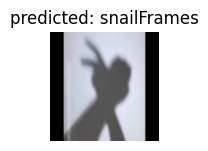

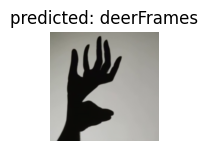

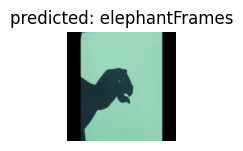

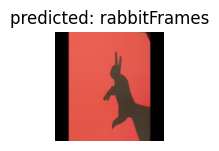

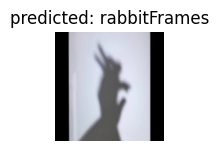

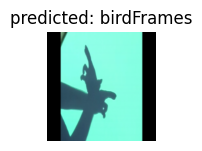

In [77]:
visualize_model8(model_ft8)

In [78]:
def train_model9(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [79]:
def visualize_model9(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [80]:
model_ft9 = models.mobilenet_v3_large(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs9 = model_ft9.classifier[3].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft9.fc = nn.Linear(num_ftrs9, 11)

model_ft9 = model_ft9.to(device)

criterion9 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft9 = optim.SGD(model_ft9.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler9 = lr_scheduler.StepLR(optimizer_ft9, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
print(model_ft9)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [82]:
model_ft9 = train_model9(model_ft9, criterion9, optimizer_ft9, exp_lr_scheduler9, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7631 Acc: 0.8332
val Loss: 1.1512 Acc: 0.6639

Epoch 1/24
----------
train Loss: 0.1083 Acc: 0.9689
val Loss: 0.8710 Acc: 0.7822

Epoch 2/24
----------
train Loss: 0.0664 Acc: 0.9815
val Loss: 0.8633 Acc: 0.8194

Epoch 3/24
----------
train Loss: 0.0481 Acc: 0.9859
val Loss: 0.8224 Acc: 0.8325

Epoch 4/24
----------
train Loss: 0.0360 Acc: 0.9904
val Loss: 1.0391 Acc: 0.8164

Epoch 5/24
----------
train Loss: 0.0320 Acc: 0.9894
val Loss: 0.8959 Acc: 0.8239

Epoch 6/24
----------
train Loss: 0.0245 Acc: 0.9930
val Loss: 0.8871 Acc: 0.8287

Epoch 7/24
----------
train Loss: 0.0233 Acc: 0.9924
val Loss: 0.8859 Acc: 0.8354

Epoch 8/24
----------
train Loss: 0.0222 Acc: 0.9935
val Loss: 0.8735 Acc: 0.8352

Epoch 9/24
----------
train Loss: 0.0204 Acc: 0.9937
val Loss: 0.8771 Acc: 0.8336

Epoch 10/24
----------
train Loss: 0.0204 Acc: 0.9944
val Loss: 0.8773 Acc: 0.8344

Epoch 11/24
----------
train Loss: 0.0225 Acc: 0.9939
val Loss: 0.9054 Acc: 0.8322

Ep

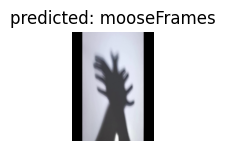

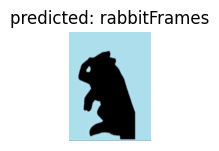

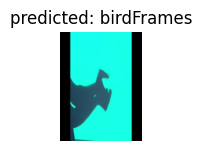

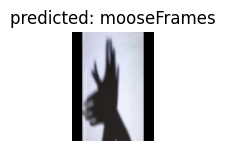

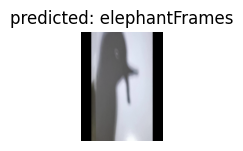

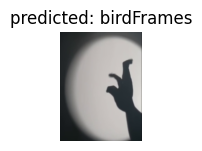

In [83]:
visualize_model9(model_ft9)

In [84]:
def train_model10(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [85]:
def visualize_model10(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [86]:
model_ft10 = models.mobilenet_v3_large(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs10 = model_ft10.classifier[3].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft10.fc = nn.Linear(num_ftrs10, 11)

model_ft10 = model_ft10.to(device)

criterion10 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft10 = optim.SGD(model_ft10.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler10 = lr_scheduler.StepLR(optimizer_ft10, step_size=5, gamma=0.1)

In [87]:
print(model_ft10)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [88]:
model_ft10 = train_model10(model_ft10, criterion10, optimizer_ft10, exp_lr_scheduler10, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7833 Acc: 0.8349
val Loss: 1.0335 Acc: 0.7073

Epoch 1/24
----------
train Loss: 0.1221 Acc: 0.9670
val Loss: 1.0671 Acc: 0.7699

Epoch 2/24
----------
train Loss: 0.0559 Acc: 0.9846
val Loss: 0.7558 Acc: 0.8041

Epoch 3/24
----------
train Loss: 0.0540 Acc: 0.9833
val Loss: 0.9490 Acc: 0.8084

Epoch 4/24
----------
train Loss: 0.0358 Acc: 0.9891
val Loss: 1.0229 Acc: 0.8105

Epoch 5/24
----------
train Loss: 0.0283 Acc: 0.9911
val Loss: 1.0195 Acc: 0.8229

Epoch 6/24
----------
train Loss: 0.0192 Acc: 0.9944
val Loss: 0.9544 Acc: 0.8328

Epoch 7/24
----------
train Loss: 0.0234 Acc: 0.9928
val Loss: 0.9088 Acc: 0.8440

Epoch 8/24
----------
train Loss: 0.0244 Acc: 0.9935
val Loss: 0.8621 Acc: 0.8461

Epoch 9/24
----------
train Loss: 0.0208 Acc: 0.9937
val Loss: 0.8980 Acc: 0.8448

Epoch 10/24
----------
train Loss: 0.0277 Acc: 0.9933
val Loss: 0.9155 Acc: 0.8400

Epoch 11/24
----------
train Loss: 0.0179 Acc: 0.9959
val Loss: 0.9052 Acc: 0.8429

Ep

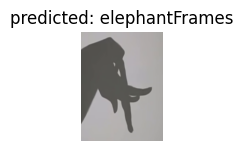

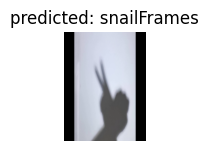

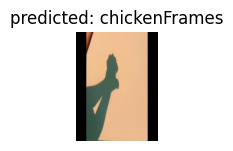

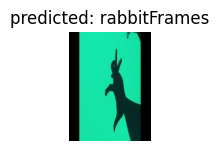

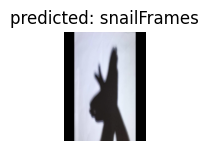

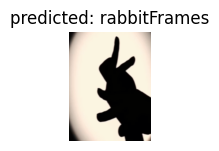

In [89]:
visualize_model9(model_ft10)

In [90]:
def train_model11(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [91]:
def visualize_model11(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [92]:
model_ft11 = models.mnasnet1_3(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs11 = model_ft11.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft11.fc = nn.Linear(num_ftrs11, 11)

model_ft11 = model_ft11.to(device)

criterion11 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft11 = optim.SGD(model_ft11.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler11 = lr_scheduler.StepLR(optimizer_ft11, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_3_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
print(model_ft11)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(72, 

In [94]:
model_ft11 = train_model11(model_ft11, criterion11, optimizer_ft11, exp_lr_scheduler11, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0887 Acc: 0.7806
val Loss: 3.9609 Acc: 0.2815

Epoch 1/24
----------
train Loss: 0.1378 Acc: 0.9642
val Loss: 2.7851 Acc: 0.4244

Epoch 2/24
----------
train Loss: 0.0896 Acc: 0.9733
val Loss: 2.1843 Acc: 0.5277

Epoch 3/24
----------
train Loss: 0.0569 Acc: 0.9844
val Loss: 1.4622 Acc: 0.6535

Epoch 4/24
----------
train Loss: 0.0498 Acc: 0.9887
val Loss: 2.1301 Acc: 0.5502

Epoch 5/24
----------
train Loss: 0.0326 Acc: 0.9928
val Loss: 1.5906 Acc: 0.6238

Epoch 6/24
----------
train Loss: 0.0309 Acc: 0.9917
val Loss: 1.1394 Acc: 0.6998

Epoch 7/24
----------
train Loss: 0.0349 Acc: 0.9913
val Loss: 1.0229 Acc: 0.7434

Epoch 8/24
----------
train Loss: 0.0268 Acc: 0.9928
val Loss: 1.0389 Acc: 0.7672

Epoch 9/24
----------
train Loss: 0.0278 Acc: 0.9933
val Loss: 1.0455 Acc: 0.7832

Epoch 10/24
----------
train Loss: 0.0258 Acc: 0.9935
val Loss: 1.0148 Acc: 0.7905

Epoch 11/24
----------
train Loss: 0.0310 Acc: 0.9928
val Loss: 0.9957 Acc: 0.7998

Ep

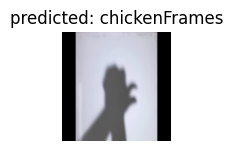

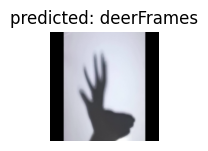

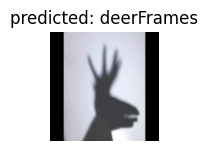

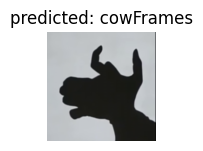

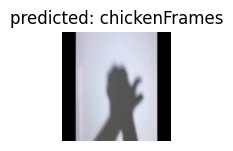

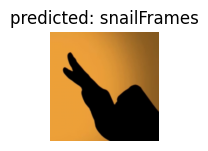

In [95]:
visualize_model11(model_ft11)

In [96]:
def train_model12(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [97]:
def visualize_model12(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [98]:
model_ft12 = models.densenet201(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs12 = model_ft12.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft12.fc = nn.Linear(num_ftrs12, 11)

model_ft12 = model_ft12.to(device)

criterion12 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft12 = optim.SGD(model_ft12.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler12 = lr_scheduler.StepLR(optimizer_ft12, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [99]:
print(model_ft12)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [100]:
model_ft12 = train_model12(model_ft12, criterion12, optimizer_ft12, exp_lr_scheduler12, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4573 Acc: 0.9007
val Loss: 1.0544 Acc: 0.7680

Epoch 1/24
----------
train Loss: 0.0489 Acc: 0.9872
val Loss: 0.7791 Acc: 0.8336

Epoch 2/24
----------
train Loss: 0.0335 Acc: 0.9909
val Loss: 0.9582 Acc: 0.8052

Epoch 3/24
----------
train Loss: 0.0238 Acc: 0.9928
val Loss: 0.7434 Acc: 0.8475

Epoch 4/24
----------
train Loss: 0.0201 Acc: 0.9954
val Loss: 0.8269 Acc: 0.8394

Epoch 5/24
----------
train Loss: 0.0122 Acc: 0.9976
val Loss: 0.7840 Acc: 0.8453

Epoch 6/24
----------
train Loss: 0.0093 Acc: 0.9976
val Loss: 0.8104 Acc: 0.8427

Epoch 7/24
----------
train Loss: 0.0075 Acc: 0.9987
val Loss: 0.8244 Acc: 0.8419

Epoch 8/24
----------
train Loss: 0.0108 Acc: 0.9967
val Loss: 0.7269 Acc: 0.8654

Epoch 9/24
----------
train Loss: 0.0102 Acc: 0.9972
val Loss: 0.6857 Acc: 0.8777

Epoch 10/24
----------
train Loss: 0.0064 Acc: 0.9987
val Loss: 0.7546 Acc: 0.8635

Epoch 11/24
----------
train Loss: 0.0111 Acc: 0.9974
val Loss: 0.7547 Acc: 0.8600

Ep

In [101]:
def train_model13(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [102]:
def visualize_model13(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [103]:
model_ft13 = models.regnet_x_32gf(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrs13 = model_ft13.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft13.fc = nn.Linear(num_ftrs13, 11)

model_ft13 = model_ft13.to(device)

criterion13 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft13 = optim.SGD(model_ft13.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler13 = lr_scheduler.StepLR(optimizer_ft13, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_32GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_32GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [104]:
print(model_ft13)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 336, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 336, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(336, 336, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [105]:
model_ft13 = train_model13(model_ft13, criterion13, optimizer_ft13, exp_lr_scheduler13, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5918 Acc: 0.8392
val Loss: 0.6511 Acc: 0.8044

Epoch 1/24
----------
train Loss: 0.0638 Acc: 0.9850
val Loss: 0.7747 Acc: 0.7886

Epoch 2/24
----------
train Loss: 0.0344 Acc: 0.9930
val Loss: 0.7491 Acc: 0.8111

Epoch 3/24
----------
train Loss: 0.0195 Acc: 0.9957
val Loss: 0.8937 Acc: 0.8108

Epoch 4/24
----------
train Loss: 0.0170 Acc: 0.9967
val Loss: 0.9077 Acc: 0.8140

Epoch 5/24
----------
train Loss: 0.0137 Acc: 0.9970
val Loss: 0.7910 Acc: 0.8220

Epoch 6/24
----------
train Loss: 0.0090 Acc: 0.9980
val Loss: 0.7428 Acc: 0.8314

Epoch 7/24
----------
train Loss: 0.0082 Acc: 0.9980
val Loss: 0.7210 Acc: 0.8373

Epoch 8/24
----------
train Loss: 0.0082 Acc: 0.9985
val Loss: 0.7514 Acc: 0.8394

Epoch 9/24
----------
train Loss: 0.0067 Acc: 0.9987
val Loss: 0.7410 Acc: 0.8424

Epoch 10/24
----------
train Loss: 0.0060 Acc: 0.9989
val Loss: 0.8106 Acc: 0.8320

Epoch 11/24
----------
train Loss: 0.0050 Acc: 0.9998
val Loss: 0.7956 Acc: 0.8328

Ep

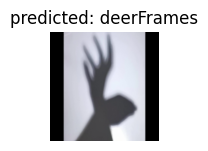

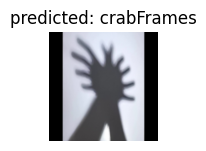

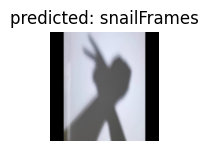

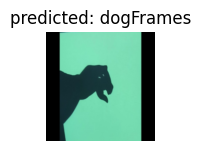

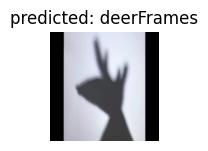

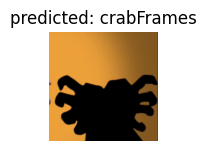

In [106]:
visualize_model11(model_ft13)

In [108]:
def train_model14(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [109]:
def visualize_model14(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [110]:
model_ft14 = models.resnet152(pretrained=True)
num_ftrs14 = model_ft14.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft14.fc = nn.Linear(num_ftrs, 11)

model_ft14 = model_ft14.to(device)

criterion14 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft14 = optim.SGD(model_ft14.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler14 = lr_scheduler.StepLR(optimizer_ft14, step_size=5, gamma=0.1)

In [111]:
model_ft14 = train_model14(model_ft14, criterion14, optimizer_ft14, exp_lr_scheduler14, num_epochs=25)

In [112]:
visualize_model14(model_ft14)

In [1]:
print('Hello, World!')

Hello, World!


In [54]:
def train_modelMaxViT(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [55]:
model_ftMaxViT = models.maxvit_t(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsMaxViT = model_ftMaxViT.classifier[3].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsMaxViT, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftMaxViT.fc = nn.Linear(num_ftrsMaxViT, 11)
model_ftMaxViT.fc = classifier_block

model_ftMaxViT = model_ftMaxViT.to(device)

criterionMaxViT = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftMaxViT = optim.SGD(model_ftMaxViT.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerMaxViT = lr_scheduler.StepLR(optimizer_ftMaxViT, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaxVit_T_Weights.IMAGENET1K_V1`. You can also use `weights=MaxVit_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
print(device)

cuda:1


In [51]:
model_ftMaxViT = train_modelMaxViT(model_ftMaxViT, criterionMaxViT, optimizer_ftMaxViT, exp_lr_schedulerMaxViT, num_epochs=50)

Epoch 1/49
----------
train Loss: 0.9852, top-2 Acc 0.8371, top-3 Acc 0.8768, Acc: 0.7539
val Loss: 1.2135, top-2 Acc 0.7985, top-3 Acc 0.8568, Acc: 0.6693
Time taken for epoch: 1m 5s
Estimated Time Remaining: 52m 48s
Epoch 2/49
----------
train Loss: 0.1141, top-2 Acc 0.9902, top-3 Acc 0.9950, Acc: 0.9702
val Loss: 0.8712, top-2 Acc 0.8956, top-3 Acc 0.9524, Acc: 0.7653
Time taken for epoch: 1m 4s
Estimated Time Remaining: 51m 19s
Epoch 3/49
----------
train Loss: 0.0645, top-2 Acc 0.9939, top-3 Acc 0.9976, Acc: 0.9833
val Loss: 0.6471, top-2 Acc 0.9144, top-3 Acc 0.9516, Acc: 0.8130
Time taken for epoch: 1m 3s
Estimated Time Remaining: 49m 10s
Epoch 4/49
----------
train Loss: 0.0519, top-2 Acc 0.9965, top-3 Acc 0.9978, Acc: 0.9857
val Loss: 0.8977, top-2 Acc 0.8384, top-3 Acc 0.9021, Acc: 0.7691
Time taken for epoch: 1m 4s
Estimated Time Remaining: 48m 52s
Epoch 5/49
----------
train Loss: 0.0327, top-2 Acc 0.9976, top-3 Acc 0.9993, Acc: 0.9917
val Loss: 1.0668, top-2 Acc 0.8135, to

val Loss: 0.8128, top-2 Acc 0.8713, top-3 Acc 0.9387, Acc: 0.8170
Time taken for epoch: 1m 42s
Estimated Time Remaining: 20m 20s
Epoch 39/49
----------
train Loss: 0.0142, top-2 Acc 0.9993, top-3 Acc 0.9998, Acc: 0.9963
val Loss: 1.0263, top-2 Acc 0.8357, top-3 Acc 0.8889, Acc: 0.7846
Time taken for epoch: 1m 44s
Estimated Time Remaining: 19m 1s
Epoch 40/49
----------
train Loss: 0.0193, top-2 Acc 0.9983, top-3 Acc 0.9998, Acc: 0.9941
val Loss: 0.9106, top-2 Acc 0.8614, top-3 Acc 0.8975, Acc: 0.8092
Time taken for epoch: 1m 43s
Estimated Time Remaining: 17m 9s
Epoch 41/49
----------
train Loss: 0.0134, top-2 Acc 0.9993, top-3 Acc 0.9996, Acc: 0.9972
val Loss: 0.6777, top-2 Acc 0.8895, top-3 Acc 0.9433, Acc: 0.8378
Time taken for epoch: 1m 43s
Estimated Time Remaining: 15m 26s
Epoch 42/49
----------
train Loss: 0.0144, top-2 Acc 0.9991, top-3 Acc 0.9996, Acc: 0.9974
val Loss: 1.0073, top-2 Acc 0.8413, top-3 Acc 0.8970, Acc: 0.7913
Time taken for epoch: 1m 44s
Estimated Time Remaining: 1

In [52]:
torch.save(model_ftMaxViT.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_MaxViT_1.pt')

In [56]:
model_ftMaxViT = train_modelMaxViT(model_ftMaxViT, criterionMaxViT, optimizer_ftMaxViT, exp_lr_schedulerMaxViT, num_epochs=50)

Epoch 1/49
----------
train Loss: 1.0104, top-2 Acc 0.8340, top-3 Acc 0.8773, Acc: 0.7439
val Loss: 1.2305, top-2 Acc 0.7552, top-3 Acc 0.8491, Acc: 0.6216
Time taken for epoch: 0m 56s
Estimated Time Remaining: 45m 51s
Epoch 2/49
----------
train Loss: 0.1464, top-2 Acc 0.9874, top-3 Acc 0.9939, Acc: 0.9611
val Loss: 0.9948, top-2 Acc 0.8360, top-3 Acc 0.9082, Acc: 0.7367
Time taken for epoch: 0m 57s
Estimated Time Remaining: 45m 13s
Epoch 3/49
----------
train Loss: 0.0851, top-2 Acc 0.9924, top-3 Acc 0.9972, Acc: 0.9759
val Loss: 0.8329, top-2 Acc 0.8619, top-3 Acc 0.9173, Acc: 0.7811
Time taken for epoch: 0m 57s
Estimated Time Remaining: 44m 34s
Epoch 4/49
----------
train Loss: 0.0520, top-2 Acc 0.9967, top-3 Acc 0.9987, Acc: 0.9848
val Loss: 0.7271, top-2 Acc 0.8975, top-3 Acc 0.9318, Acc: 0.8170
Time taken for epoch: 0m 57s
Estimated Time Remaining: 43m 48s
Epoch 5/49
----------
train Loss: 0.0416, top-2 Acc 0.9967, top-3 Acc 0.9987, Acc: 0.9870
val Loss: 1.0872, top-2 Acc 0.8287

val Loss: 0.8408, top-2 Acc 0.8654, top-3 Acc 0.9069, Acc: 0.8092
Time taken for epoch: 0m 59s
Estimated Time Remaining: 11m 44s
Epoch 39/49
----------
train Loss: 0.0251, top-2 Acc 0.9993, top-3 Acc 0.9998, Acc: 0.9924
val Loss: 0.6724, top-2 Acc 0.9079, top-3 Acc 0.9433, Acc: 0.8274
Time taken for epoch: 0m 59s
Estimated Time Remaining: 10m 44s
Epoch 40/49
----------
train Loss: 0.0259, top-2 Acc 0.9980, top-3 Acc 0.9996, Acc: 0.9926
val Loss: 0.6903, top-2 Acc 0.9120, top-3 Acc 0.9454, Acc: 0.8186
Time taken for epoch: 0m 59s
Estimated Time Remaining: 9m 47s
Epoch 41/49
----------
train Loss: 0.0211, top-2 Acc 0.9996, top-3 Acc 1.0000, Acc: 0.9950
val Loss: 0.8198, top-2 Acc 0.8833, top-3 Acc 0.9296, Acc: 0.8057
Time taken for epoch: 0m 59s
Estimated Time Remaining: 8m 47s
Epoch 42/49
----------
train Loss: 0.0228, top-2 Acc 0.9989, top-3 Acc 0.9993, Acc: 0.9935
val Loss: 0.9525, top-2 Acc 0.8708, top-3 Acc 0.9066, Acc: 0.7819
Time taken for epoch: 0m 59s
Estimated Time Remaining: 7

In [57]:
torch.save(model_ftMaxViT.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_MaxViT_1_Aug_CB.pt')

In [20]:
model = models.maxvit_t(pretrained=True)
loaded_model = torch.load('/home/dlpc01/Rifat/saved_models/HSPR_MaxViT_1.pt')
# print(loaded_model.keys())
model.load_state_dict(loaded_model, strict=False)
model.eval().to(device)

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [27]:
# import cv2
# test_image = cv2.imread('/home/dlpc01/Rifat/CSE 4836 Pattern Recognition Lab/data2/val/dogFrames/dog_369.PNG')
# imshow(torch.tensor(test_image))
def visualize_modelMaxViT(model, num_images=6):
    was_training = model.training
    model.eval().to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('ground truth: {}, predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

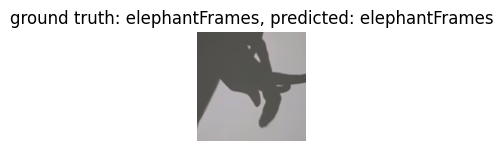

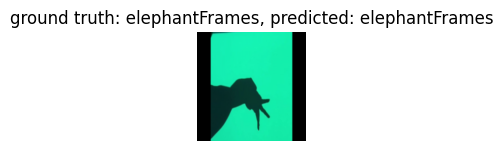

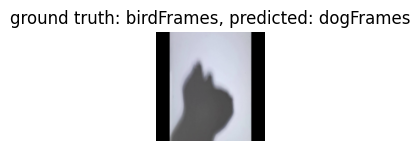

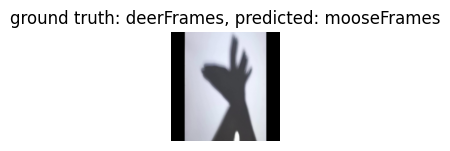

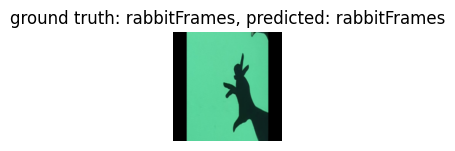

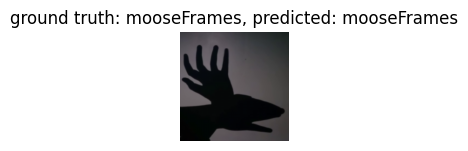

In [29]:
visualize_modelMaxViT(model)

In [41]:
def train_modelDenseNet201(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [58]:
model_ftDenseNet201 = models.densenet201(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsDenseNet201 = model_ftDenseNet201.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsDenseNet201, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftDenseNet201.fc = nn.Linear(num_ftrsDenseNet201, 11)

model_ftDenseNet201 = model_ftDenseNet201.to(device)

criterionDenseNet201 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftDenseNet201 = optim.SGD(model_ftDenseNet201.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerDenseNet201 = lr_scheduler.StepLR(optimizer_ftDenseNet201, step_size=5, gamma=0.1)

In [32]:
model_ftDenseNet201 = train_modelDenseNet201(model_ftDenseNet201, criterionDenseNet201, optimizer_ftDenseNet201, exp_lr_schedulerDenseNet201, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.4715, top-2 Acc 0.9374, top-3 Acc 0.9531, Acc: 0.8985
val Loss: 1.0605, top-2 Acc 0.8678, top-3 Acc 0.9066, Acc: 0.7816
Time taken for epoch: 1m 40s
Estimated Time Remaining: 81m 60s
Epoch 2/50
----------
train Loss: 0.0643, top-2 Acc 0.9941, top-3 Acc 0.9967, Acc: 0.9807
val Loss: 0.6779, top-2 Acc 0.9010, top-3 Acc 0.9221, Acc: 0.8579
Time taken for epoch: 1m 36s
Estimated Time Remaining: 76m 44s
Epoch 3/50
----------
train Loss: 0.0322, top-2 Acc 0.9980, top-3 Acc 0.9991, Acc: 0.9915
val Loss: 1.0007, top-2 Acc 0.8962, top-3 Acc 0.9208, Acc: 0.7988
Time taken for epoch: 1m 36s
Estimated Time Remaining: 75m 20s
Epoch 4/50
----------
train Loss: 0.0217, top-2 Acc 0.9987, top-3 Acc 0.9993, Acc: 0.9939
val Loss: 0.8096, top-2 Acc 0.9023, top-3 Acc 0.9205, Acc: 0.8480
Time taken for epoch: 1m 39s
Estimated Time Remaining: 75m 40s
Epoch 5/50
----------
train Loss: 0.0172, top-2 Acc 0.9989, top-3 Acc 0.9996, Acc: 0.9961
val Loss: 0.8985, top-2 Acc 0.8879

val Loss: 0.8952, top-2 Acc 0.8980, top-3 Acc 0.9227, Acc: 0.8456
Time taken for epoch: 1m 29s
Estimated Time Remaining: 17m 53s
Epoch 39/50
----------
train Loss: 0.0061, top-2 Acc 0.9998, top-3 Acc 1.0000, Acc: 0.9989
val Loss: 0.8958, top-2 Acc 0.8898, top-3 Acc 0.9224, Acc: 0.8410
Time taken for epoch: 1m 18s
Estimated Time Remaining: 14m 20s
Epoch 40/50
----------
train Loss: 0.0098, top-2 Acc 0.9993, top-3 Acc 0.9996, Acc: 0.9980
val Loss: 0.8163, top-2 Acc 0.9061, top-3 Acc 0.9323, Acc: 0.8427
Time taken for epoch: 1m 33s
Estimated Time Remaining: 15m 29s
Epoch 41/50
----------
train Loss: 0.0069, top-2 Acc 0.9996, top-3 Acc 0.9998, Acc: 0.9987
val Loss: 0.7938, top-2 Acc 0.9109, top-3 Acc 0.9307, Acc: 0.8507
Time taken for epoch: 1m 34s
Estimated Time Remaining: 14m 9s
Epoch 42/50
----------
train Loss: 0.0067, top-2 Acc 0.9998, top-3 Acc 1.0000, Acc: 0.9985
val Loss: 0.8582, top-2 Acc 0.8994, top-3 Acc 0.9227, Acc: 0.8448
Time taken for epoch: 1m 35s
Estimated Time Remaining: 

In [33]:
torch.save(model_ftDenseNet201.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_DenseNet201_1.pt')

In [59]:
model_ftDenseNet201 = train_modelDenseNet201(model_ftDenseNet201, criterionDenseNet201, optimizer_ftDenseNet201, exp_lr_schedulerDenseNet201, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.5407, top-2 Acc 0.9244, top-3 Acc 0.9411, Acc: 0.8766
val Loss: 0.8591, top-2 Acc 0.8638, top-3 Acc 0.9138, Acc: 0.7784
Time taken for epoch: 0m 54s
Estimated Time Remaining: 43m 46s
Epoch 2/50
----------
train Loss: 0.1040, top-2 Acc 0.9861, top-3 Acc 0.9917, Acc: 0.9713
val Loss: 0.7779, top-2 Acc 0.8691, top-3 Acc 0.9082, Acc: 0.8039
Time taken for epoch: 0m 53s
Estimated Time Remaining: 42m 32s
Epoch 3/50
----------
train Loss: 0.0545, top-2 Acc 0.9946, top-3 Acc 0.9980, Acc: 0.9846
val Loss: 0.7194, top-2 Acc 0.8978, top-3 Acc 0.9253, Acc: 0.8472
Time taken for epoch: 0m 53s
Estimated Time Remaining: 41m 34s
Epoch 4/50
----------
train Loss: 0.0451, top-2 Acc 0.9954, top-3 Acc 0.9980, Acc: 0.9883
val Loss: 0.7822, top-2 Acc 0.8948, top-3 Acc 0.9286, Acc: 0.8432
Time taken for epoch: 0m 53s
Estimated Time Remaining: 40m 48s
Epoch 5/50
----------
train Loss: 0.0317, top-2 Acc 0.9972, top-3 Acc 0.9987, Acc: 0.9920
val Loss: 0.6489, top-2 Acc 0.9245

val Loss: 0.7497, top-2 Acc 0.9168, top-3 Acc 0.9441, Acc: 0.8619
Time taken for epoch: 0m 53s
Estimated Time Remaining: 10m 35s
Epoch 39/50
----------
train Loss: 0.0126, top-2 Acc 0.9985, top-3 Acc 0.9989, Acc: 0.9978
val Loss: 0.6256, top-2 Acc 0.9331, top-3 Acc 0.9476, Acc: 0.8908
Time taken for epoch: 0m 53s
Estimated Time Remaining: 9m 38s
Epoch 40/50
----------
train Loss: 0.0158, top-2 Acc 0.9985, top-3 Acc 0.9989, Acc: 0.9957
val Loss: 0.6438, top-2 Acc 0.9310, top-3 Acc 0.9465, Acc: 0.8860
Time taken for epoch: 0m 53s
Estimated Time Remaining: 8m 48s
Epoch 41/50
----------
train Loss: 0.0137, top-2 Acc 0.9989, top-3 Acc 0.9996, Acc: 0.9957
val Loss: 0.7135, top-2 Acc 0.9224, top-3 Acc 0.9435, Acc: 0.8691
Time taken for epoch: 0m 53s
Estimated Time Remaining: 7m 55s
Epoch 42/50
----------
train Loss: 0.0119, top-2 Acc 0.9989, top-3 Acc 0.9993, Acc: 0.9967
val Loss: 0.6524, top-2 Acc 0.9323, top-3 Acc 0.9473, Acc: 0.8881
Time taken for epoch: 0m 53s
Estimated Time Remaining: 7m

In [60]:
torch.save(model_ftDenseNet201.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_DenseNet201_1_Aug_CB.pt')

In [34]:
model1 = models.densenet201(pretrained=True)
loaded_model1 = torch.load('/home/dlpc01/Rifat/saved_models/HSPR_DenseNet201_1.pt')
# print(loaded_model.keys())
model1.load_state_dict(loaded_model1, strict=False)
model1.eval().to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [37]:
def train_modelResNet152(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [51]:
model_ftResNet152 = models.resnet152(pretrained=True)
num_ftrsResNet152 = model_ftResNet152.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsResNet152, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftResNet152.fc = nn.Linear(num_ftrsResNet152, 11)

model_ftResNet152 = model_ftResNet152.to(device)

criterionResNet152 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftResNet152 = optim.SGD(model_ftResNet152.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerResNet152 = lr_scheduler.StepLR(optimizer_ftResNet152, step_size=5, gamma=0.1)

In [40]:
model_ftResNet152 = train_modelResNet152(model_ftResNet152, criterionResNet152, optimizer_ftResNet152, exp_lr_schedulerResNet152, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.4055, top-2 Acc 0.9320, top-3 Acc 0.9494, Acc: 0.8872
val Loss: 0.9395, top-2 Acc 0.8459, top-3 Acc 0.8975, Acc: 0.7407
Time taken for epoch: 1m 44s
Estimated Time Remaining: 85m 13s
Epoch 2/50
----------
train Loss: 0.0728, top-2 Acc 0.9939, top-3 Acc 0.9976, Acc: 0.9807
val Loss: 0.7940, top-2 Acc 0.8777, top-3 Acc 0.9200, Acc: 0.8188
Time taken for epoch: 1m 37s
Estimated Time Remaining: 77m 57s
Epoch 3/50
----------
train Loss: 0.0373, top-2 Acc 0.9983, top-3 Acc 0.9989, Acc: 0.9928
val Loss: 1.0028, top-2 Acc 0.8697, top-3 Acc 0.9162, Acc: 0.7969
Time taken for epoch: 1m 40s
Estimated Time Remaining: 78m 42s
Epoch 4/50
----------
train Loss: 0.0388, top-2 Acc 0.9970, top-3 Acc 0.9985, Acc: 0.9891
val Loss: 0.6605, top-2 Acc 0.9104, top-3 Acc 0.9374, Acc: 0.8461
Time taken for epoch: 2m 29s
Estimated Time Remaining: 113m 58s
Epoch 5/50
----------
train Loss: 0.0271, top-2 Acc 0.9972, top-3 Acc 0.9983, Acc: 0.9924
val Loss: 0.6529, top-2 Acc 0.901

val Loss: 0.7090, top-2 Acc 0.9055, top-3 Acc 0.9355, Acc: 0.8523
Time taken for epoch: 1m 27s
Estimated Time Remaining: 17m 30s
Epoch 39/50
----------
train Loss: 0.0083, top-2 Acc 0.9996, top-3 Acc 0.9998, Acc: 0.9989
val Loss: 0.6866, top-2 Acc 0.9133, top-3 Acc 0.9352, Acc: 0.8512
Time taken for epoch: 1m 39s
Estimated Time Remaining: 18m 12s
Epoch 40/50
----------
train Loss: 0.0107, top-2 Acc 0.9991, top-3 Acc 0.9998, Acc: 0.9983
val Loss: 0.7229, top-2 Acc 0.9018, top-3 Acc 0.9315, Acc: 0.8501
Time taken for epoch: 1m 31s
Estimated Time Remaining: 15m 12s
Epoch 41/50
----------
train Loss: 0.0112, top-2 Acc 0.9991, top-3 Acc 0.9993, Acc: 0.9978
val Loss: 0.7109, top-2 Acc 0.9018, top-3 Acc 0.9302, Acc: 0.8512
Time taken for epoch: 1m 38s
Estimated Time Remaining: 14m 46s
Epoch 42/50
----------
train Loss: 0.0072, top-2 Acc 0.9998, top-3 Acc 0.9998, Acc: 0.9989
val Loss: 0.7434, top-2 Acc 0.9085, top-3 Acc 0.9334, Acc: 0.8504
Time taken for epoch: 1m 30s
Estimated Time Remaining:

In [41]:
torch.save(model_ftResNet152.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_ResNet152_1.pt')

In [52]:
model_ftResNet152 = train_modelResNet152(model_ftResNet152, criterionResNet152, optimizer_ftResNet152, exp_lr_schedulerResNet152, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.5335, top-2 Acc 0.9248, top-3 Acc 0.9411, Acc: 0.8801
val Loss: 1.1273, top-2 Acc 0.8710, top-3 Acc 0.9294, Acc: 0.7656
Time taken for epoch: 0m 52s
Estimated Time Remaining: 42m 40s
Epoch 2/50
----------
train Loss: 0.1012, top-2 Acc 0.9896, top-3 Acc 0.9928, Acc: 0.9737
val Loss: 1.0086, top-2 Acc 0.8903, top-3 Acc 0.9157, Acc: 0.7950
Time taken for epoch: 0m 52s
Estimated Time Remaining: 41m 54s
Epoch 3/50
----------
train Loss: 0.0595, top-2 Acc 0.9944, top-3 Acc 0.9978, Acc: 0.9833
val Loss: 1.1099, top-2 Acc 0.8785, top-3 Acc 0.9162, Acc: 0.8012
Time taken for epoch: 0m 53s
Estimated Time Remaining: 41m 8s
Epoch 4/50
----------
train Loss: 0.0472, top-2 Acc 0.9963, top-3 Acc 0.9978, Acc: 0.9878
val Loss: 0.8052, top-2 Acc 0.9168, top-3 Acc 0.9398, Acc: 0.8451
Time taken for epoch: 0m 53s
Estimated Time Remaining: 40m 39s
Epoch 5/50
----------
train Loss: 0.0332, top-2 Acc 0.9985, top-3 Acc 0.9989, Acc: 0.9926
val Loss: 0.8252, top-2 Acc 0.9037,

val Loss: 0.7546, top-2 Acc 0.9178, top-3 Acc 0.9462, Acc: 0.8595
Time taken for epoch: 0m 54s
Estimated Time Remaining: 10m 46s
Epoch 39/50
----------
train Loss: 0.0091, top-2 Acc 0.9996, top-3 Acc 1.0000, Acc: 0.9980
val Loss: 0.5932, top-2 Acc 0.9323, top-3 Acc 0.9671, Acc: 0.8777
Time taken for epoch: 0m 54s
Estimated Time Remaining: 9m 55s
Epoch 40/50
----------
train Loss: 0.0147, top-2 Acc 0.9989, top-3 Acc 0.9993, Acc: 0.9963
val Loss: 0.6331, top-2 Acc 0.9272, top-3 Acc 0.9526, Acc: 0.8732
Time taken for epoch: 0m 54s
Estimated Time Remaining: 9m 1s
Epoch 41/50
----------
train Loss: 0.0152, top-2 Acc 0.9985, top-3 Acc 0.9993, Acc: 0.9974
val Loss: 0.6298, top-2 Acc 0.9264, top-3 Acc 0.9639, Acc: 0.8729
Time taken for epoch: 0m 54s
Estimated Time Remaining: 8m 7s
Epoch 42/50
----------
train Loss: 0.0122, top-2 Acc 0.9989, top-3 Acc 0.9996, Acc: 0.9967
val Loss: 0.7206, top-2 Acc 0.9162, top-3 Acc 0.9443, Acc: 0.8579
Time taken for epoch: 0m 54s
Estimated Time Remaining: 7m 1

In [53]:
torch.save(model_ftResNet152.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_ResNet152_1_Aug_CB.pt')

In [47]:
model2 = models.resnet152(pretrained=True)
model2.fc = nn.Linear(num_ftrsResNet152, 11)
loaded_model2 = torch.load('/home/dlpc01/Rifat/saved_models/HSPR_ResNet152_1.pt')
# print(loaded_model.keys())
model2.load_state_dict(loaded_model2, strict=False)
model2.eval().to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
def train_modelViTL32(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [62]:
model_ftViTL32 = models.vit_l_32(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsViTL32 = model_ftViTL32.heads.head.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsMaxViT, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftViTL32.fc = nn.Linear(num_ftrsViTL32, 11)
model_ftMaxViT.fc = classifier_block

model_ftViTL32 = model_ftViTL32.to(device)

criterionViTL32 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftViTL32 = optim.SGD(model_ftViTL32.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerViTL32 = lr_scheduler.StepLR(optimizer_ftViTL32, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model_ftViTL32 = train_modelViTL32(model_ftViTL32, criterionViTL32, optimizer_ftViTL32, exp_lr_schedulerViTL32, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.1526, top-2 Acc 0.7875, top-3 Acc 0.8449, Acc: 0.6772
val Loss: 1.8143, top-2 Acc 0.6283, top-3 Acc 0.7008, Acc: 0.4991
Time taken for epoch: 1m 14s
Estimated Time Remaining: 60m 14s
Epoch 2/50
----------
train Loss: 0.3588, top-2 Acc 0.9516, top-3 Acc 0.9681, Acc: 0.8840
val Loss: 1.8719, top-2 Acc 0.6623, top-3 Acc 0.7517, Acc: 0.5325
Time taken for epoch: 1m 12s
Estimated Time Remaining: 57m 48s
Epoch 3/50
----------
train Loss: 0.2159, top-2 Acc 0.9720, top-3 Acc 0.9835, Acc: 0.9346
val Loss: 1.4586, top-2 Acc 0.7196, top-3 Acc 0.7824, Acc: 0.6222
Time taken for epoch: 1m 12s
Estimated Time Remaining: 56m 33s
Epoch 4/50
----------
train Loss: 0.1428, top-2 Acc 0.9831, top-3 Acc 0.9913, Acc: 0.9544
val Loss: 1.7095, top-2 Acc 0.7287, top-3 Acc 0.7993, Acc: 0.6120
Time taken for epoch: 1m 13s
Estimated Time Remaining: 55m 49s
Epoch 5/50
----------
train Loss: 0.1282, top-2 Acc 0.9878, top-3 Acc 0.9915, Acc: 0.9579
val Loss: 1.4853, top-2 Acc 0.7594

In [8]:
torch.save(model_ftViTL32.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_ViTL32_1.pt')

In [63]:
model_ftViTL32 = train_modelViTL32(model_ftViTL32, criterionViTL32, optimizer_ftViTL32, exp_lr_schedulerViTL32, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.1812, top-2 Acc 0.7793, top-3 Acc 0.8399, Acc: 0.6680
val Loss: 1.7138, top-2 Acc 0.6345, top-3 Acc 0.7281, Acc: 0.4897
Time taken for epoch: 1m 8s
Estimated Time Remaining: 55m 19s
Epoch 2/50
----------
train Loss: 0.4093, top-2 Acc 0.9359, top-3 Acc 0.9633, Acc: 0.8675
val Loss: 1.5900, top-2 Acc 0.6850, top-3 Acc 0.7592, Acc: 0.5876
Time taken for epoch: 1m 9s
Estimated Time Remaining: 55m 22s
Epoch 3/50
----------
train Loss: 0.2626, top-2 Acc 0.9635, top-3 Acc 0.9824, Acc: 0.9124
val Loss: 1.6060, top-2 Acc 0.7372, top-3 Acc 0.7923, Acc: 0.6358
Time taken for epoch: 1m 10s
Estimated Time Remaining: 55m 1s
Epoch 4/50
----------
train Loss: 0.1910, top-2 Acc 0.9772, top-3 Acc 0.9874, Acc: 0.9376
val Loss: 1.4135, top-2 Acc 0.7412, top-3 Acc 0.8237, Acc: 0.6503
Time taken for epoch: 1m 15s
Estimated Time Remaining: 57m 32s
Epoch 5/50
----------
train Loss: 0.1590, top-2 Acc 0.9811, top-3 Acc 0.9876, Acc: 0.9487
val Loss: 1.1864, top-2 Acc 0.8071, t

val Loss: 0.9797, top-2 Acc 0.8357, top-3 Acc 0.9096, Acc: 0.7677
Time taken for epoch: 1m 11s
Estimated Time Remaining: 14m 11s
Epoch 39/50
----------
train Loss: 0.0461, top-2 Acc 0.9957, top-3 Acc 0.9978, Acc: 0.9848
val Loss: 0.9797, top-2 Acc 0.8357, top-3 Acc 0.9096, Acc: 0.7677
Time taken for epoch: 1m 11s
Estimated Time Remaining: 13m 5s
Epoch 40/50
----------
train Loss: 0.0424, top-2 Acc 0.9952, top-3 Acc 0.9985, Acc: 0.9883
val Loss: 0.9797, top-2 Acc 0.8357, top-3 Acc 0.9096, Acc: 0.7677
Time taken for epoch: 1m 9s
Estimated Time Remaining: 11m 34s
Epoch 41/50
----------
train Loss: 0.0444, top-2 Acc 0.9954, top-3 Acc 0.9978, Acc: 0.9874
val Loss: 0.9797, top-2 Acc 0.8357, top-3 Acc 0.9096, Acc: 0.7677
Time taken for epoch: 1m 10s
Estimated Time Remaining: 10m 33s
Epoch 42/50
----------
train Loss: 0.0437, top-2 Acc 0.9965, top-3 Acc 0.9976, Acc: 0.9859
val Loss: 0.9797, top-2 Acc 0.8357, top-3 Acc 0.9096, Acc: 0.7677
Time taken for epoch: 1m 11s
Estimated Time Remaining: 9

In [64]:
torch.save(model_ftViTL32.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_ViTL32_1_Aug_CB.pt')

In [69]:
def train_modelInceptionV3(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(299,299), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if len(outputs) == 2:
                        _, preds = torch.max(outputs[0], 1)
                        _, topK0preds = torch.topk(outputs[0], k[0], 1)
                        _, topK1preds = torch.topk(outputs[0], k[1], 1)
                        loss = criterion(outputs[0], labels)
                    else:
                        _, preds = torch.max(outputs, 1)
                        _, topK0preds = torch.topk(outputs, k[0], 1)
                        _, topK1preds = torch.topk(outputs, k[1], 1)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [70]:
model_ftInceptionV3 = models.inception_v3(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsInceptionV3 = model_ftInceptionV3.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsInceptionV3, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftInceptionV3.fc = nn.Linear(num_ftrsInceptionV3, 11)
model_ftInceptionV3.fc = classifier_block

model_ftInceptionV3 = model_ftInceptionV3.to(device)

criterionInceptionV3 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftInceptionV3 = optim.SGD(model_ftInceptionV3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerInceptionV3 = lr_scheduler.StepLR(optimizer_ftInceptionV3, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model_ftInceptionV3 = train_modelInceptionV3(model_ftInceptionV3, criterionInceptionV3, optimizer_ftInceptionV3, exp_lr_schedulerInceptionV3, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.6556, top-2 Acc 0.8849, top-3 Acc 0.9116, Acc: 0.8201
val Loss: 0.8849, top-2 Acc 0.8400, top-3 Acc 0.8895, Acc: 0.7287
Time taken for epoch: 0m 55s
Estimated Time Remaining: 44m 35s
Epoch 2/50
----------
train Loss: 0.1138, top-2 Acc 0.9887, top-3 Acc 0.9930, Acc: 0.9737
val Loss: 0.8962, top-2 Acc 0.8582, top-3 Acc 0.8978, Acc: 0.7931
Time taken for epoch: 0m 52s
Estimated Time Remaining: 41m 44s
Epoch 3/50
----------
train Loss: 0.0617, top-2 Acc 0.9954, top-3 Acc 0.9980, Acc: 0.9839
val Loss: 0.6377, top-2 Acc 0.8991, top-3 Acc 0.9227, Acc: 0.8558
Time taken for epoch: 0m 53s
Estimated Time Remaining: 41m 20s
Epoch 4/50
----------
train Loss: 0.0547, top-2 Acc 0.9963, top-3 Acc 0.9978, Acc: 0.9889
val Loss: 0.7669, top-2 Acc 0.8919, top-3 Acc 0.9219, Acc: 0.8360
Time taken for epoch: 0m 51s
Estimated Time Remaining: 39m 25s
Epoch 5/50
----------
train Loss: 0.0393, top-2 Acc 0.9972, top-3 Acc 0.9987, Acc: 0.9911
val Loss: 0.6360, top-2 Acc 0.9299

val Loss: 0.5936, top-2 Acc 0.9331, top-3 Acc 0.9545, Acc: 0.8785
Time taken for epoch: 0m 54s
Estimated Time Remaining: 10m 53s
Epoch 39/50
----------
train Loss: 0.0123, top-2 Acc 0.9993, top-3 Acc 0.9998, Acc: 0.9978
val Loss: 0.6186, top-2 Acc 0.9227, top-3 Acc 0.9465, Acc: 0.8718
Time taken for epoch: 0m 55s
Estimated Time Remaining: 10m 0s
Epoch 40/50
----------
train Loss: 0.0138, top-2 Acc 0.9996, top-3 Acc 0.9998, Acc: 0.9972
val Loss: 0.6712, top-2 Acc 0.9219, top-3 Acc 0.9459, Acc: 0.8670
Time taken for epoch: 0m 54s
Estimated Time Remaining: 9m 4s
Epoch 41/50
----------
train Loss: 0.0110, top-2 Acc 0.9998, top-3 Acc 0.9998, Acc: 0.9991
val Loss: 0.6372, top-2 Acc 0.9294, top-3 Acc 0.9500, Acc: 0.8734
Time taken for epoch: 0m 54s
Estimated Time Remaining: 8m 4s
Epoch 42/50
----------
train Loss: 0.0130, top-2 Acc 0.9993, top-3 Acc 0.9998, Acc: 0.9980
val Loss: 0.7177, top-2 Acc 0.9173, top-3 Acc 0.9417, Acc: 0.8609
Time taken for epoch: 0m 54s
Estimated Time Remaining: 7m 1

In [13]:
torch.save(model_ftInceptionV3.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_InceptionV3.pt')

In [46]:
model_ftInceptionV3 = train_modelInceptionV3(model_ftInceptionV3, criterionInceptionV3, optimizer_ftInceptionV3, exp_lr_schedulerInceptionV3, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.2840, top-2 Acc 0.7224, top-3 Acc 0.7860, Acc: 0.5977
val Loss: 0.9206, top-2 Acc 0.8469, top-3 Acc 0.8975, Acc: 0.7177
Time taken for epoch: 0m 42s
Estimated Time Remaining: 34m 10s
Epoch 2/50
----------
train Loss: 0.4198, top-2 Acc 0.9448, top-3 Acc 0.9668, Acc: 0.8877
val Loss: 1.0576, top-2 Acc 0.8424, top-3 Acc 0.8972, Acc: 0.7220
Time taken for epoch: 0m 43s
Estimated Time Remaining: 34m 15s
Epoch 3/50
----------
train Loss: 0.2889, top-2 Acc 0.9670, top-3 Acc 0.9770, Acc: 0.9268
val Loss: 0.8404, top-2 Acc 0.9133, top-3 Acc 0.9435, Acc: 0.7862
Time taken for epoch: 0m 42s
Estimated Time Remaining: 32m 46s
Epoch 4/50
----------
train Loss: 0.2138, top-2 Acc 0.9787, top-3 Acc 0.9867, Acc: 0.9511
val Loss: 0.5966, top-2 Acc 0.9077, top-3 Acc 0.9467, Acc: 0.8448
Time taken for epoch: 0m 41s
Estimated Time Remaining: 31m 27s
Epoch 5/50
----------
train Loss: 0.1748, top-2 Acc 0.9826, top-3 Acc 0.9907, Acc: 0.9607
val Loss: 0.7195, top-2 Acc 0.9042

val Loss: 0.4389, top-2 Acc 0.9395, top-3 Acc 0.9583, Acc: 0.8948
Time taken for epoch: 0m 42s
Estimated Time Remaining: 8m 18s
Epoch 39/50
----------
train Loss: 0.0811, top-2 Acc 0.9939, top-3 Acc 0.9959, Acc: 0.9844
val Loss: 0.5193, top-2 Acc 0.9350, top-3 Acc 0.9564, Acc: 0.8895
Time taken for epoch: 0m 42s
Estimated Time Remaining: 7m 38s
Epoch 40/50
----------
train Loss: 0.0809, top-2 Acc 0.9930, top-3 Acc 0.9957, Acc: 0.9839
val Loss: 0.4589, top-2 Acc 0.9409, top-3 Acc 0.9569, Acc: 0.8999
Time taken for epoch: 0m 41s
Estimated Time Remaining: 6m 55s
Epoch 41/50
----------
train Loss: 0.0754, top-2 Acc 0.9933, top-3 Acc 0.9957, Acc: 0.9859
val Loss: 0.4592, top-2 Acc 0.9385, top-3 Acc 0.9588, Acc: 0.8975
Time taken for epoch: 0m 41s
Estimated Time Remaining: 6m 11s
Epoch 42/50
----------
train Loss: 0.0743, top-2 Acc 0.9939, top-3 Acc 0.9957, Acc: 0.9846
val Loss: 0.4292, top-2 Acc 0.9427, top-3 Acc 0.9607, Acc: 0.8922
Time taken for epoch: 0m 41s
Estimated Time Remaining: 5m 

In [47]:
torch.save(model_ftInceptionV3.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_InceptionV3_Aug_CB.pt')

In [71]:
model_ftInceptionV3 = train_modelInceptionV3(model_ftInceptionV3, criterionInceptionV3, optimizer_ftInceptionV3, exp_lr_schedulerInceptionV3, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.2659, top-2 Acc 0.7276, top-3 Acc 0.7910, Acc: 0.6059
val Loss: 1.4077, top-2 Acc 0.6476, top-3 Acc 0.7324, Acc: 0.5397
Time taken for epoch: 0m 44s
Estimated Time Remaining: 36m 7s
Epoch 2/50
----------
train Loss: 0.5039, top-2 Acc 0.9220, top-3 Acc 0.9485, Acc: 0.8649
val Loss: 1.1748, top-2 Acc 0.7412, top-3 Acc 0.7870, Acc: 0.6492
Time taken for epoch: 0m 42s
Estimated Time Remaining: 33m 26s
Epoch 3/50
----------
train Loss: 0.3649, top-2 Acc 0.9426, top-3 Acc 0.9607, Acc: 0.9042
val Loss: 1.0732, top-2 Acc 0.7578, top-3 Acc 0.8081, Acc: 0.6500
Time taken for epoch: 0m 42s
Estimated Time Remaining: 32m 57s
Epoch 4/50
----------
train Loss: 0.2922, top-2 Acc 0.9596, top-3 Acc 0.9694, Acc: 0.9192
val Loss: 1.1406, top-2 Acc 0.7870, top-3 Acc 0.8314, Acc: 0.6749
Time taken for epoch: 0m 42s
Estimated Time Remaining: 32m 27s
Epoch 5/50
----------
train Loss: 0.2853, top-2 Acc 0.9552, top-3 Acc 0.9692, Acc: 0.9246
val Loss: 1.0344, top-2 Acc 0.7800,

val Loss: 0.8420, top-2 Acc 0.8368, top-3 Acc 0.8737, Acc: 0.7720
Time taken for epoch: 0m 42s
Estimated Time Remaining: 8m 26s
Epoch 39/50
----------
train Loss: 0.1669, top-2 Acc 0.9741, top-3 Acc 0.9815, Acc: 0.9552
val Loss: 0.9030, top-2 Acc 0.8306, top-3 Acc 0.8686, Acc: 0.7594
Time taken for epoch: 0m 42s
Estimated Time Remaining: 7m 47s
Epoch 40/50
----------
train Loss: 0.1752, top-2 Acc 0.9737, top-3 Acc 0.9802, Acc: 0.9544
val Loss: 0.8445, top-2 Acc 0.8295, top-3 Acc 0.8799, Acc: 0.7648
Time taken for epoch: 0m 42s
Estimated Time Remaining: 7m 1s
Epoch 41/50
----------
train Loss: 0.1773, top-2 Acc 0.9718, top-3 Acc 0.9798, Acc: 0.9516
val Loss: 0.9659, top-2 Acc 0.8336, top-3 Acc 0.8600, Acc: 0.7683
Time taken for epoch: 0m 42s
Estimated Time Remaining: 6m 19s
Epoch 42/50
----------
train Loss: 0.1798, top-2 Acc 0.9715, top-3 Acc 0.9800, Acc: 0.9502
val Loss: 0.8792, top-2 Acc 0.8253, top-3 Acc 0.8576, Acc: 0.7616
Time taken for epoch: 0m 42s
Estimated Time Remaining: 5m 3

In [72]:
torch.save(model_ftInceptionV3.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_InceptionV3_Aug_CB_Dil.pt')

In [33]:
def train_modelMobileNetV3Large(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [70]:
model_ftMobileNetV3Large = models.mobilenet_v3_large(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsMobileNetV3Large = model_ftMobileNetV3Large.classifier[3].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsMobileNetV3Large, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
model_ftMobileNetV3Large.fc = classifier_block
# model_ftMobileNetV3Large.fc = nn.Linear(num_ftrsMobileNetV3Large, 11)

model_ftMobileNetV3Large = model_ftMobileNetV3Large.to(device)

criterionMobileNetV3Large = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftMobileNetV3Large = optim.SGD(model_ftMobileNetV3Large.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerMobileNetV3Large = lr_scheduler.StepLR(optimizer_ftMobileNetV3Large, step_size=5, gamma=0.1)

In [16]:
model_ftMobileNetV3Large = train_modelMobileNetV3Large(model_ftMobileNetV3Large, criterionMobileNetV3Large, optimizer_ftMobileNetV3Large, exp_lr_schedulerMobileNetV3Large, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.7832, top-2 Acc 0.8833, top-3 Acc 0.9079, Acc: 0.8251
val Loss: 1.2944, top-2 Acc 0.7811, top-3 Acc 0.8368, Acc: 0.6872
Time taken for epoch: 0m 39s
Estimated Time Remaining: 31m 39s
Epoch 2/50
----------
train Loss: 0.1179, top-2 Acc 0.9854, top-3 Acc 0.9930, Acc: 0.9663
val Loss: 1.1418, top-2 Acc 0.8378, top-3 Acc 0.8635, Acc: 0.7750
Time taken for epoch: 0m 38s
Estimated Time Remaining: 30m 36s
Epoch 3/50
----------
train Loss: 0.0717, top-2 Acc 0.9922, top-3 Acc 0.9965, Acc: 0.9759
val Loss: 0.8258, top-2 Acc 0.8729, top-3 Acc 0.9053, Acc: 0.8207
Time taken for epoch: 0m 38s
Estimated Time Remaining: 29m 52s
Epoch 4/50
----------
train Loss: 0.0431, top-2 Acc 0.9970, top-3 Acc 0.9985, Acc: 0.9859
val Loss: 0.7400, top-2 Acc 0.9005, top-3 Acc 0.9328, Acc: 0.8432
Time taken for epoch: 0m 38s
Estimated Time Remaining: 29m 18s
Epoch 5/50
----------
train Loss: 0.0393, top-2 Acc 0.9963, top-3 Acc 0.9983, Acc: 0.9878
val Loss: 0.6812, top-2 Acc 0.9088

val Loss: 0.7373, top-2 Acc 0.8975, top-3 Acc 0.9318, Acc: 0.8542
Time taken for epoch: 0m 39s
Estimated Time Remaining: 7m 46s
Epoch 39/50
----------
train Loss: 0.0217, top-2 Acc 0.9987, top-3 Acc 0.9998, Acc: 0.9944
val Loss: 0.7222, top-2 Acc 0.8983, top-3 Acc 0.9326, Acc: 0.8558
Time taken for epoch: 0m 39s
Estimated Time Remaining: 7m 5s
Epoch 40/50
----------
train Loss: 0.0212, top-2 Acc 0.9991, top-3 Acc 0.9998, Acc: 0.9944
val Loss: 0.7282, top-2 Acc 0.8980, top-3 Acc 0.9328, Acc: 0.8550
Time taken for epoch: 0m 39s
Estimated Time Remaining: 6m 29s
Epoch 41/50
----------
train Loss: 0.0167, top-2 Acc 0.9991, top-3 Acc 1.0000, Acc: 0.9954
val Loss: 0.7310, top-2 Acc 0.8988, top-3 Acc 0.9323, Acc: 0.8542
Time taken for epoch: 0m 47s
Estimated Time Remaining: 7m 2s
Epoch 42/50
----------
train Loss: 0.0191, top-2 Acc 0.9980, top-3 Acc 0.9993, Acc: 0.9944
val Loss: 0.7396, top-2 Acc 0.8959, top-3 Acc 0.9323, Acc: 0.8544
Time taken for epoch: 0m 54s
Estimated Time Remaining: 7m 15

In [17]:
torch.save(model_ftMobileNetV3Large.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_MobileNetV3Large.pt')

In [71]:
model_ftMobileNetV3Large = train_modelMobileNetV3Large(model_ftMobileNetV3Large, criterionMobileNetV3Large, optimizer_ftMobileNetV3Large, exp_lr_schedulerMobileNetV3Large, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.8587, top-2 Acc 0.8675, top-3 Acc 0.8985, Acc: 0.8017
val Loss: 1.0592, top-2 Acc 0.8159, top-3 Acc 0.8903, Acc: 0.6784
Time taken for epoch: 0m 37s
Estimated Time Remaining: 30m 16s
Epoch 2/50
----------
train Loss: 0.1501, top-2 Acc 0.9831, top-3 Acc 0.9904, Acc: 0.9546
val Loss: 1.0004, top-2 Acc 0.8397, top-3 Acc 0.9130, Acc: 0.7511
Time taken for epoch: 0m 37s
Estimated Time Remaining: 29m 39s
Epoch 3/50
----------
train Loss: 0.0810, top-2 Acc 0.9920, top-3 Acc 0.9959, Acc: 0.9755
val Loss: 1.0092, top-2 Acc 0.8485, top-3 Acc 0.9216, Acc: 0.7768
Time taken for epoch: 0m 37s
Estimated Time Remaining: 28m 48s
Epoch 4/50
----------
train Loss: 0.0645, top-2 Acc 0.9939, top-3 Acc 0.9967, Acc: 0.9809
val Loss: 0.9718, top-2 Acc 0.8568, top-3 Acc 0.9138, Acc: 0.8092
Time taken for epoch: 0m 37s
Estimated Time Remaining: 28m 22s
Epoch 5/50
----------
train Loss: 0.0486, top-2 Acc 0.9963, top-3 Acc 0.9978, Acc: 0.9826
val Loss: 0.7135, top-2 Acc 0.8951

val Loss: 0.6670, top-2 Acc 0.9050, top-3 Acc 0.9566, Acc: 0.8536
Time taken for epoch: 0m 37s
Estimated Time Remaining: 7m 21s
Epoch 39/50
----------
train Loss: 0.0321, top-2 Acc 0.9961, top-3 Acc 0.9985, Acc: 0.9902
val Loss: 0.6415, top-2 Acc 0.9104, top-3 Acc 0.9604, Acc: 0.8582
Time taken for epoch: 0m 37s
Estimated Time Remaining: 6m 43s
Epoch 40/50
----------
train Loss: 0.0297, top-2 Acc 0.9972, top-3 Acc 0.9987, Acc: 0.9930
val Loss: 0.6459, top-2 Acc 0.9093, top-3 Acc 0.9585, Acc: 0.8563
Time taken for epoch: 0m 37s
Estimated Time Remaining: 6m 7s
Epoch 41/50
----------
train Loss: 0.0315, top-2 Acc 0.9970, top-3 Acc 0.9980, Acc: 0.9922
val Loss: 0.6531, top-2 Acc 0.9050, top-3 Acc 0.9564, Acc: 0.8555
Time taken for epoch: 0m 37s
Estimated Time Remaining: 5m 30s
Epoch 42/50
----------
train Loss: 0.0278, top-2 Acc 0.9974, top-3 Acc 0.9989, Acc: 0.9920
val Loss: 0.6428, top-2 Acc 0.9096, top-3 Acc 0.9572, Acc: 0.8576
Time taken for epoch: 0m 37s
Estimated Time Remaining: 4m 5

In [72]:
torch.save(model_ftMobileNetV3Large.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_MobileNetV3Large_Aug_CB.pt')

In [68]:
def train_modelRegNetX32GF(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [74]:
model_ftRegNetX32GF = models.regnet_x_32gf(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsRegNetX32GF = model_ftRegNetX32GF.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsRegNetX32GF, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftRegNetX32GF.fc = nn.Linear(num_ftrsRegNetX32GF, 11)
model_ftRegNetX32GF.fc = classifier_block

model_ftRegNetX32GF = model_ftRegNetX32GF.to(device)

criterionRegNetX32GF = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftRegNetX32GF = optim.SGD(model_ftRegNetX32GF.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerRegNetX32GF = lr_scheduler.StepLR(optimizer_ftRegNetX32GF, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_32GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_32GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
model_ftRegNetX32GF = train_modelRegNetX32GF(model_ftRegNetX32GF, criterionRegNetX32GF, optimizer_ftRegNetX32GF, exp_lr_schedulerRegNetX32GF, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.8045, top-2 Acc 0.8603, top-3 Acc 0.8957, Acc: 0.7797
val Loss: 0.7781, top-2 Acc 0.8804, top-3 Acc 0.9294, Acc: 0.7477
Time taken for epoch: 2m 1s
Estimated Time Remaining: 98m 56s
Epoch 2/50
----------
train Loss: 0.1861, top-2 Acc 0.9835, top-3 Acc 0.9909, Acc: 0.9589
val Loss: 0.8767, top-2 Acc 0.8475, top-3 Acc 0.8857, Acc: 0.7725
Time taken for epoch: 2m 6s
Estimated Time Remaining: 100m 60s
Epoch 3/50
----------
train Loss: 0.1338, top-2 Acc 0.9883, top-3 Acc 0.9937, Acc: 0.9681
val Loss: 0.7051, top-2 Acc 0.8793, top-3 Acc 0.9106, Acc: 0.8172
Time taken for epoch: 2m 10s
Estimated Time Remaining: 101m 38s
Epoch 4/50
----------
train Loss: 0.0978, top-2 Acc 0.9922, top-3 Acc 0.9954, Acc: 0.9794
val Loss: 0.7001, top-2 Acc 0.8705, top-3 Acc 0.9093, Acc: 0.8242
Time taken for epoch: 2m 11s
Estimated Time Remaining: 100m 37s
Epoch 5/50
----------
train Loss: 0.0958, top-2 Acc 0.9917, top-3 Acc 0.9954, Acc: 0.9791
val Loss: 0.6095, top-2 Acc 0.899

val Loss: 0.6182, top-2 Acc 0.9170, top-3 Acc 0.9427, Acc: 0.8654
Time taken for epoch: 2m 14s
Estimated Time Remaining: 26m 49s
Epoch 39/50
----------
train Loss: 0.0378, top-2 Acc 0.9978, top-3 Acc 0.9989, Acc: 0.9944
val Loss: 0.6017, top-2 Acc 0.9114, top-3 Acc 0.9363, Acc: 0.8713
Time taken for epoch: 2m 15s
Estimated Time Remaining: 24m 41s
Epoch 40/50
----------
train Loss: 0.0378, top-2 Acc 0.9972, top-3 Acc 0.9983, Acc: 0.9928
val Loss: 0.5721, top-2 Acc 0.9109, top-3 Acc 0.9382, Acc: 0.8734
Time taken for epoch: 2m 14s
Estimated Time Remaining: 22m 23s
Epoch 41/50
----------
train Loss: 0.0355, top-2 Acc 0.9983, top-3 Acc 0.9989, Acc: 0.9946
val Loss: 0.6463, top-2 Acc 0.9112, top-3 Acc 0.9417, Acc: 0.8630
Time taken for epoch: 2m 15s
Estimated Time Remaining: 20m 11s
Epoch 42/50
----------
train Loss: 0.0352, top-2 Acc 0.9989, top-3 Acc 0.9998, Acc: 0.9939
val Loss: 0.6197, top-2 Acc 0.9031, top-3 Acc 0.9334, Acc: 0.8657
Time taken for epoch: 2m 15s
Estimated Time Remaining:

In [21]:
torch.save(model_ftRegNetX32GF.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_RegNetX32GF.pt')

In [ ]:
model_ftRegNetX32GF = train_modelRegNetX32GF(model_ftRegNetX32GF, criterionRegNetX32GF, optimizer_ftRegNetX32GF, exp_lr_schedulerRegNetX32GF, num_epochs=50)

In [76]:
torch.save(model_ftRegNetX32GF.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_RegNetX32GF_Aug_CB.pt')

In [77]:
def train_modelConvNextLarge(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [78]:
model_ftConvNextLarge = models.convnext_large(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsConvNextLarge = model_ftConvNextLarge.classifier[2].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsConvNextLarge, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftConvNextLarge.fc = nn.Linear(num_ftrsConvNextLarge, 11)
model_ftConvNextLarge.fc = classifier_block

model_ftConvNextLarge = model_ftConvNextLarge.to(device)

criterionConvNextLarge = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftConvNextLarge = optim.SGD(model_ftConvNextLarge.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerConvNextLarge = lr_scheduler.StepLR(optimizer_ftConvNextLarge, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
model_ftConvNextLarge = train_modelConvNextLarge(model_ftConvNextLarge, criterionConvNextLarge, optimizer_ftConvNextLarge, exp_lr_schedulerConvNextLarge, num_epochs=50)

Epoch 1/50
----------
train Loss: 2.3352, top-2 Acc 0.3541, top-3 Acc 0.4454, Acc: 0.2307
val Loss: 2.0799, top-2 Acc 0.4956, top-3 Acc 0.5617, Acc: 0.3776
Time taken for epoch: 3m 42s
Estimated Time Remaining: 181m 6s
Epoch 2/50
----------
train Loss: 0.3934, top-2 Acc 0.9457, top-3 Acc 0.9665, Acc: 0.8883
val Loss: 1.1686, top-2 Acc 0.8113, top-3 Acc 0.8713, Acc: 0.6615
Time taken for epoch: 3m 43s
Estimated Time Remaining: 178m 2s
Epoch 3/50
----------
train Loss: 0.1083, top-2 Acc 0.9883, top-3 Acc 0.9941, Acc: 0.9702
val Loss: 1.0423, top-2 Acc 0.8571, top-3 Acc 0.9189, Acc: 0.7474
Time taken for epoch: 3m 45s
Estimated Time Remaining: 176m 12s
Epoch 4/50
----------
train Loss: 0.0557, top-2 Acc 0.9957, top-3 Acc 0.9983, Acc: 0.9844
val Loss: 1.0434, top-2 Acc 0.8646, top-3 Acc 0.9023, Acc: 0.7835
Time taken for epoch: 3m 45s
Estimated Time Remaining: 172m 27s
Epoch 5/50
----------
train Loss: 0.0396, top-2 Acc 0.9970, top-3 Acc 0.9989, Acc: 0.9887
val Loss: 0.7890, top-2 Acc 0.88

val Loss: 0.9177, top-2 Acc 0.8753, top-3 Acc 0.9181, Acc: 0.8277
Time taken for epoch: 3m 47s
Estimated Time Remaining: 45m 23s
Epoch 39/50
----------
train Loss: 0.0152, top-2 Acc 0.9996, top-3 Acc 0.9998, Acc: 0.9967
val Loss: 0.9177, top-2 Acc 0.8753, top-3 Acc 0.9181, Acc: 0.8277
Time taken for epoch: 3m 46s
Estimated Time Remaining: 41m 27s
Epoch 40/50
----------
train Loss: 0.0144, top-2 Acc 0.9996, top-3 Acc 0.9998, Acc: 0.9970
val Loss: 0.9177, top-2 Acc 0.8753, top-3 Acc 0.9181, Acc: 0.8277
Time taken for epoch: 3m 49s
Estimated Time Remaining: 38m 9s
Epoch 41/50
----------
train Loss: 0.0161, top-2 Acc 0.9991, top-3 Acc 1.0000, Acc: 0.9963
val Loss: 0.9177, top-2 Acc 0.8753, top-3 Acc 0.9181, Acc: 0.8277
Time taken for epoch: 3m 50s
Estimated Time Remaining: 34m 33s
Epoch 42/50
----------
train Loss: 0.0153, top-2 Acc 0.9996, top-3 Acc 1.0000, Acc: 0.9974
val Loss: 0.9177, top-2 Acc 0.8753, top-3 Acc 0.9181, Acc: 0.8277
Time taken for epoch: 3m 50s
Estimated Time Remaining: 

In [25]:
torch.save(model_ftConvNextLarge.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_ConvNextLarge.pt')

In [79]:
model_ftConvNextLarge = train_modelConvNextLarge(model_ftConvNextLarge, criterionConvNextLarge, optimizer_ftConvNextLarge, exp_lr_schedulerConvNextLarge, num_epochs=50)

Epoch 1/50
----------
train Loss: 2.5138, top-2 Acc 0.2674, top-3 Acc 0.3717, Acc: 0.1514
val Loss: 2.4606, top-2 Acc 0.3754, top-3 Acc 0.4571, Acc: 0.2066
Time taken for epoch: 4m 4s
Estimated Time Remaining: 198m 56s
Epoch 2/50
----------
train Loss: 1.1695, top-2 Acc 0.7619, top-3 Acc 0.8238, Acc: 0.6274
val Loss: 1.5841, top-2 Acc 0.6420, top-3 Acc 0.7332, Acc: 0.5213
Time taken for epoch: 3m 54s
Estimated Time Remaining: 186m 59s
Epoch 3/50
----------
train Loss: 0.2753, top-2 Acc 0.9635, top-3 Acc 0.9781, Acc: 0.9205
val Loss: 1.1006, top-2 Acc 0.7982, top-3 Acc 0.8539, Acc: 0.6848
Time taken for epoch: 4m 7s
Estimated Time Remaining: 193m 18s
Epoch 4/50
----------
train Loss: 0.1241, top-2 Acc 0.9852, top-3 Acc 0.9909, Acc: 0.9648
val Loss: 0.9409, top-2 Acc 0.8726, top-3 Acc 0.9162, Acc: 0.7704
Time taken for epoch: 3m 56s
Estimated Time Remaining: 181m 13s
Epoch 5/50
----------
train Loss: 0.0752, top-2 Acc 0.9924, top-3 Acc 0.9959, Acc: 0.9794
val Loss: 0.8345, top-2 Acc 0.89

val Loss: 0.7015, top-2 Acc 0.8951, top-3 Acc 0.9451, Acc: 0.8392
Time taken for epoch: 3m 54s
Estimated Time Remaining: 46m 47s
Epoch 39/50
----------
train Loss: 0.0251, top-2 Acc 0.9991, top-3 Acc 0.9996, Acc: 0.9941
val Loss: 0.7015, top-2 Acc 0.8951, top-3 Acc 0.9451, Acc: 0.8392
Time taken for epoch: 4m 1s
Estimated Time Remaining: 44m 16s
Epoch 40/50
----------
train Loss: 0.0252, top-2 Acc 0.9991, top-3 Acc 1.0000, Acc: 0.9939
val Loss: 0.7015, top-2 Acc 0.8951, top-3 Acc 0.9451, Acc: 0.8392
Time taken for epoch: 4m 0s
Estimated Time Remaining: 40m 2s
Epoch 41/50
----------
train Loss: 0.0305, top-2 Acc 0.9963, top-3 Acc 0.9987, Acc: 0.9917
val Loss: 0.7015, top-2 Acc 0.8951, top-3 Acc 0.9451, Acc: 0.8392
Time taken for epoch: 4m 0s
Estimated Time Remaining: 36m 0s
Epoch 42/50
----------
train Loss: 0.0331, top-2 Acc 0.9972, top-3 Acc 0.9983, Acc: 0.9924
val Loss: 0.7015, top-2 Acc 0.8951, top-3 Acc 0.9451, Acc: 0.8392
Time taken for epoch: 3m 55s
Estimated Time Remaining: 31m 

In [80]:
torch.save(model_ftConvNextLarge.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_ConvNextLarge_Aug_CB.pt')

In [81]:
def train_modelGoogLeNet(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [82]:
model_ftGoogLeNet = models.googlenet(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsGoogLeNet = model_ftGoogLeNet.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsGoogLeNet, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
model_ftGoogLeNet.fc = classifier_block
# model_ftGoogLeNet.fc = nn.Linear(num_ftrsGoogLeNet, 11)

model_ftGoogLeNet = model_ftGoogLeNet.to(device)

criterionGoogLeNet = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftGoogLeNet = optim.SGD(model_ftGoogLeNet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerGoogLeNet = lr_scheduler.StepLR(optimizer_ftGoogLeNet, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
model_ftGoogLeNet = train_modelGoogLeNet(model_ftGoogLeNet, criterionGoogLeNet, optimizer_ftGoogLeNet, exp_lr_schedulerGoogLeNet, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.9529, top-2 Acc 0.8488, top-3 Acc 0.8846, Acc: 0.7608
val Loss: 1.1290, top-2 Acc 0.7717, top-3 Acc 0.8352, Acc: 0.6286
Time taken for epoch: 0m 46s
Estimated Time Remaining: 37m 28s
Epoch 2/50
----------
train Loss: 0.1827, top-2 Acc 0.9831, top-3 Acc 0.9920, Acc: 0.9615
val Loss: 0.9523, top-2 Acc 0.8212, top-3 Acc 0.8702, Acc: 0.7281
Time taken for epoch: 0m 47s
Estimated Time Remaining: 37m 15s
Epoch 3/50
----------
train Loss: 0.0929, top-2 Acc 0.9928, top-3 Acc 0.9972, Acc: 0.9822
val Loss: 0.6489, top-2 Acc 0.8959, top-3 Acc 0.9227, Acc: 0.8092
Time taken for epoch: 0m 47s
Estimated Time Remaining: 36m 50s
Epoch 4/50
----------
train Loss: 0.0623, top-2 Acc 0.9965, top-3 Acc 0.9980, Acc: 0.9887
val Loss: 1.0553, top-2 Acc 0.8370, top-3 Acc 0.8911, Acc: 0.7626
Time taken for epoch: 0m 47s
Estimated Time Remaining: 35m 57s
Epoch 5/50
----------
train Loss: 0.0494, top-2 Acc 0.9972, top-3 Acc 0.9983, Acc: 0.9896
val Loss: 0.8396, top-2 Acc 0.8590

val Loss: 0.8268, top-2 Acc 0.8710, top-3 Acc 0.9106, Acc: 0.8143
Time taken for epoch: 0m 46s
Estimated Time Remaining: 9m 17s
Epoch 39/50
----------
train Loss: 0.0247, top-2 Acc 0.9993, top-3 Acc 0.9998, Acc: 0.9963
val Loss: 0.7842, top-2 Acc 0.8678, top-3 Acc 0.9071, Acc: 0.8164
Time taken for epoch: 0m 47s
Estimated Time Remaining: 8m 38s
Epoch 40/50
----------
train Loss: 0.0338, top-2 Acc 0.9980, top-3 Acc 0.9996, Acc: 0.9926
val Loss: 0.7746, top-2 Acc 0.8761, top-3 Acc 0.9176, Acc: 0.8194
Time taken for epoch: 0m 45s
Estimated Time Remaining: 7m 35s
Epoch 41/50
----------
train Loss: 0.0289, top-2 Acc 0.9985, top-3 Acc 0.9993, Acc: 0.9954
val Loss: 0.6771, top-2 Acc 0.8906, top-3 Acc 0.9294, Acc: 0.8309
Time taken for epoch: 0m 47s
Estimated Time Remaining: 6m 59s
Epoch 42/50
----------
train Loss: 0.0315, top-2 Acc 0.9987, top-3 Acc 0.9991, Acc: 0.9944
val Loss: 0.7310, top-2 Acc 0.8849, top-3 Acc 0.9205, Acc: 0.8188
Time taken for epoch: 0m 48s
Estimated Time Remaining: 6m 

In [29]:
torch.save(model_ftGoogLeNet.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_GoogLeNet.pt')

In [83]:
model_ftGoogLeNet = train_modelGoogLeNet(model_ftGoogLeNet, criterionGoogLeNet, optimizer_ftGoogLeNet, exp_lr_schedulerGoogLeNet, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.2279, top-2 Acc 0.7415, top-3 Acc 0.8047, Acc: 0.6153
val Loss: 1.0509, top-2 Acc 0.8004, top-3 Acc 0.8657, Acc: 0.6687
Time taken for epoch: 0m 37s
Estimated Time Remaining: 29m 59s
Epoch 2/50
----------
train Loss: 0.3786, top-2 Acc 0.9542, top-3 Acc 0.9759, Acc: 0.8938
val Loss: 0.6463, top-2 Acc 0.8825, top-3 Acc 0.9197, Acc: 0.7875
Time taken for epoch: 0m 37s
Estimated Time Remaining: 29m 13s
Epoch 3/50
----------
train Loss: 0.2542, top-2 Acc 0.9692, top-3 Acc 0.9839, Acc: 0.9335
val Loss: 0.7654, top-2 Acc 0.8563, top-3 Acc 0.8873, Acc: 0.7875
Time taken for epoch: 0m 37s
Estimated Time Remaining: 28m 38s
Epoch 4/50
----------
train Loss: 0.1817, top-2 Acc 0.9807, top-3 Acc 0.9913, Acc: 0.9518
val Loss: 0.6419, top-2 Acc 0.8900, top-3 Acc 0.9245, Acc: 0.8138
Time taken for epoch: 0m 36s
Estimated Time Remaining: 27m 58s
Epoch 5/50
----------
train Loss: 0.1387, top-2 Acc 0.9859, top-3 Acc 0.9922, Acc: 0.9622
val Loss: 0.5668, top-2 Acc 0.9079

val Loss: 0.5478, top-2 Acc 0.9146, top-3 Acc 0.9462, Acc: 0.8405
Time taken for epoch: 0m 36s
Estimated Time Remaining: 7m 17s
Epoch 39/50
----------
train Loss: 0.0769, top-2 Acc 0.9939, top-3 Acc 0.9974, Acc: 0.9828
val Loss: 0.6061, top-2 Acc 0.9026, top-3 Acc 0.9540, Acc: 0.8413
Time taken for epoch: 0m 36s
Estimated Time Remaining: 6m 40s
Epoch 40/50
----------
train Loss: 0.0826, top-2 Acc 0.9939, top-3 Acc 0.9961, Acc: 0.9837
val Loss: 0.5882, top-2 Acc 0.9136, top-3 Acc 0.9449, Acc: 0.8419
Time taken for epoch: 0m 36s
Estimated Time Remaining: 6m 4s
Epoch 41/50
----------
train Loss: 0.0762, top-2 Acc 0.9946, top-3 Acc 0.9972, Acc: 0.9839
val Loss: 0.5691, top-2 Acc 0.9069, top-3 Acc 0.9371, Acc: 0.8453
Time taken for epoch: 0m 36s
Estimated Time Remaining: 5m 28s
Epoch 42/50
----------
train Loss: 0.0900, top-2 Acc 0.9926, top-3 Acc 0.9959, Acc: 0.9796
val Loss: 0.5447, top-2 Acc 0.9112, top-3 Acc 0.9422, Acc: 0.8424
Time taken for epoch: 0m 37s
Estimated Time Remaining: 4m 5

In [84]:
torch.save(model_ftGoogLeNet.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_GoogLeNet_Aug_CB.pt')

In [85]:
def train_modelSwinV2B(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [86]:
model_ftSwinV2B = models.swin_v2_b(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsSwinV2B = model_ftSwinV2B.head.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsSwinV2B, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftSwinV2B.fc = nn.Linear(num_ftrsSwinV2B, 11)
model_ftSwinV2B.fc = classifier_block

model_ftSwinV2B = model_ftSwinV2B.to(device)

criterionSwinV2B = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftSwinV2B = optim.SGD(model_ftSwinV2B.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerSwinV2B = lr_scheduler.StepLR(optimizer_ftSwinV2B, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
model_ftSwinV2B = train_modelSwinV2B(model_ftSwinV2B, criterionSwinV2B, optimizer_ftSwinV2B, exp_lr_schedulerSwinV2B, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.6503, top-2 Acc 0.6170, top-3 Acc 0.6902, Acc: 0.4982
val Loss: 1.4730, top-2 Acc 0.7527, top-3 Acc 0.8587, Acc: 0.5662
Time taken for epoch: 2m 41s
Estimated Time Remaining: 131m 27s
Epoch 2/50
----------
train Loss: 0.1951, top-2 Acc 0.9768, top-3 Acc 0.9896, Acc: 0.9413
val Loss: 1.0729, top-2 Acc 0.8330, top-3 Acc 0.8734, Acc: 0.7172
Time taken for epoch: 2m 37s
Estimated Time Remaining: 125m 38s
Epoch 3/50
----------
train Loss: 0.0922, top-2 Acc 0.9917, top-3 Acc 0.9946, Acc: 0.9707
val Loss: 1.0995, top-2 Acc 0.8600, top-3 Acc 0.9256, Acc: 0.7487
Time taken for epoch: 2m 37s
Estimated Time Remaining: 123m 7s
Epoch 4/50
----------
train Loss: 0.0582, top-2 Acc 0.9933, top-3 Acc 0.9972, Acc: 0.9820
val Loss: 0.8121, top-2 Acc 0.8804, top-3 Acc 0.9219, Acc: 0.8017
Time taken for epoch: 2m 36s
Estimated Time Remaining: 119m 57s
Epoch 5/50
----------
train Loss: 0.0358, top-2 Acc 0.9967, top-3 Acc 0.9985, Acc: 0.9887
val Loss: 1.3051, top-2 Acc 0.8

val Loss: 1.0204, top-2 Acc 0.8825, top-3 Acc 0.9286, Acc: 0.8306
Time taken for epoch: 2m 42s
Estimated Time Remaining: 32m 29s
Epoch 39/50
----------
train Loss: 0.0135, top-2 Acc 0.9991, top-3 Acc 0.9998, Acc: 0.9957
val Loss: 1.0204, top-2 Acc 0.8825, top-3 Acc 0.9286, Acc: 0.8306
Time taken for epoch: 2m 42s
Estimated Time Remaining: 29m 46s
Epoch 40/50
----------
train Loss: 0.0139, top-2 Acc 0.9998, top-3 Acc 0.9998, Acc: 0.9952
val Loss: 1.0204, top-2 Acc 0.8825, top-3 Acc 0.9286, Acc: 0.8306
Time taken for epoch: 2m 31s
Estimated Time Remaining: 25m 15s
Epoch 41/50
----------
train Loss: 0.0098, top-2 Acc 0.9993, top-3 Acc 0.9998, Acc: 0.9967
val Loss: 1.0204, top-2 Acc 0.8825, top-3 Acc 0.9286, Acc: 0.8306
Time taken for epoch: 2m 32s
Estimated Time Remaining: 22m 47s
Epoch 42/50
----------
train Loss: 0.0111, top-2 Acc 0.9996, top-3 Acc 1.0000, Acc: 0.9957
val Loss: 1.0204, top-2 Acc 0.8825, top-3 Acc 0.9286, Acc: 0.8306
Time taken for epoch: 2m 31s
Estimated Time Remaining:

In [33]:
torch.save(model_ftSwinV2B.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_SwinV2B.pt')

In [87]:
model_ftSwinV2B = train_modelSwinV2B(model_ftSwinV2B, criterionSwinV2B, optimizer_ftSwinV2B, exp_lr_schedulerSwinV2B, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.6113, top-2 Acc 0.6309, top-3 Acc 0.7074, Acc: 0.5205
val Loss: 1.1609, top-2 Acc 0.7913, top-3 Acc 0.8887, Acc: 0.6465
Time taken for epoch: 1m 26s
Estimated Time Remaining: 70m 0s
Epoch 2/50
----------
train Loss: 0.2373, top-2 Acc 0.9718, top-3 Acc 0.9863, Acc: 0.9231
val Loss: 0.9517, top-2 Acc 0.8440, top-3 Acc 0.9162, Acc: 0.7313
Time taken for epoch: 1m 29s
Estimated Time Remaining: 71m 15s
Epoch 3/50
----------
train Loss: 0.1278, top-2 Acc 0.9846, top-3 Acc 0.9920, Acc: 0.9594
val Loss: 1.2168, top-2 Acc 0.8464, top-3 Acc 0.8898, Acc: 0.7287
Time taken for epoch: 1m 31s
Estimated Time Remaining: 70m 58s
Epoch 4/50
----------
train Loss: 0.0788, top-2 Acc 0.9913, top-3 Acc 0.9970, Acc: 0.9746
val Loss: 1.0584, top-2 Acc 0.8584, top-3 Acc 0.8938, Acc: 0.7849
Time taken for epoch: 1m 34s
Estimated Time Remaining: 72m 15s
Epoch 5/50
----------
train Loss: 0.0789, top-2 Acc 0.9928, top-3 Acc 0.9974, Acc: 0.9724
val Loss: 1.1224, top-2 Acc 0.8488,

val Loss: 0.8195, top-2 Acc 0.8986, top-3 Acc 0.9261, Acc: 0.8429
Time taken for epoch: 1m 34s
Estimated Time Remaining: 18m 46s
Epoch 39/50
----------
train Loss: 0.0234, top-2 Acc 0.9991, top-3 Acc 0.9996, Acc: 0.9915
val Loss: 0.8195, top-2 Acc 0.8986, top-3 Acc 0.9261, Acc: 0.8429
Time taken for epoch: 1m 31s
Estimated Time Remaining: 16m 41s
Epoch 40/50
----------
train Loss: 0.0275, top-2 Acc 0.9983, top-3 Acc 0.9996, Acc: 0.9917
val Loss: 0.8195, top-2 Acc 0.8986, top-3 Acc 0.9261, Acc: 0.8429
Time taken for epoch: 1m 38s
Estimated Time Remaining: 16m 15s
Epoch 41/50
----------
train Loss: 0.0259, top-2 Acc 0.9989, top-3 Acc 0.9993, Acc: 0.9926
val Loss: 0.8195, top-2 Acc 0.8986, top-3 Acc 0.9261, Acc: 0.8429
Time taken for epoch: 1m 31s
Estimated Time Remaining: 13m 40s
Epoch 42/50
----------
train Loss: 0.0290, top-2 Acc 0.9980, top-3 Acc 0.9991, Acc: 0.9917
val Loss: 0.8195, top-2 Acc 0.8986, top-3 Acc 0.9261, Acc: 0.8429
Time taken for epoch: 1m 33s
Estimated Time Remaining:

In [88]:
torch.save(model_ftSwinV2B.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_SwinV2B_Aug_CB.pt')

In [89]:
def train_modelMNasNet13(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [90]:
model_ftMNasNet13 = models.mnasnet1_3(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsMNasNet13 = model_ftMNasNet13.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsMNasNet13, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftMNasNet13.fc = nn.Linear(num_ftrsMNasNet13, 11)
model_ftMNasNet13.fc = classifier_block
model_ftMNasNet13 = model_ftMNasNet13.to(device)

criterionMNasNet13 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftMNasNet13 = optim.SGD(model_ftMNasNet13.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerMNasNet13 = lr_scheduler.StepLR(optimizer_ftMNasNet13, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_3_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
model_ftMNasNet13 = train_modelMNasNet13(model_ftMNasNet13, criterionMNasNet13, optimizer_ftMNasNet13, exp_lr_schedulerMNasNet13, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.2491, top-2 Acc 0.8190, top-3 Acc 0.8549, Acc: 0.7489
val Loss: 122.2048, top-2 Acc 0.1806, top-3 Acc 0.2561, Acc: 0.0795
Time taken for epoch: 0m 39s
Estimated Time Remaining: 31m 51s
Epoch 2/50
----------
train Loss: 0.1723, top-2 Acc 0.9781, top-3 Acc 0.9881, Acc: 0.9533
val Loss: 65.1077, top-2 Acc 0.1857, top-3 Acc 0.2502, Acc: 0.1030
Time taken for epoch: 0m 39s
Estimated Time Remaining: 30m 48s
Epoch 3/50
----------
train Loss: 0.0896, top-2 Acc 0.9922, top-3 Acc 0.9957, Acc: 0.9776
val Loss: 38.4189, top-2 Acc 0.1755, top-3 Acc 0.2505, Acc: 0.0921
Time taken for epoch: 0m 38s
Estimated Time Remaining: 30m 7s
Epoch 4/50
----------
train Loss: 0.0572, top-2 Acc 0.9952, top-3 Acc 0.9974, Acc: 0.9850
val Loss: 3.4659, top-2 Acc 0.5052, top-3 Acc 0.5700, Acc: 0.3586
Time taken for epoch: 0m 39s
Estimated Time Remaining: 29m 32s
Epoch 5/50
----------
train Loss: 0.0466, top-2 Acc 0.9952, top-3 Acc 0.9972, Acc: 0.9883
val Loss: 2.3602, top-2 Acc 0.6

val Loss: 0.8335, top-2 Acc 0.8774, top-3 Acc 0.9063, Acc: 0.8336
Time taken for epoch: 0m 39s
Estimated Time Remaining: 7m 47s
Epoch 39/50
----------
train Loss: 0.0336, top-2 Acc 0.9965, top-3 Acc 0.9985, Acc: 0.9928
val Loss: 0.8332, top-2 Acc 0.8774, top-3 Acc 0.9063, Acc: 0.8336
Time taken for epoch: 0m 39s
Estimated Time Remaining: 7m 9s
Epoch 40/50
----------
train Loss: 0.0276, top-2 Acc 0.9976, top-3 Acc 0.9989, Acc: 0.9937
val Loss: 0.8335, top-2 Acc 0.8774, top-3 Acc 0.9066, Acc: 0.8333
Time taken for epoch: 0m 39s
Estimated Time Remaining: 6m 30s
Epoch 41/50
----------
train Loss: 0.0276, top-2 Acc 0.9985, top-3 Acc 0.9993, Acc: 0.9930
val Loss: 0.8345, top-2 Acc 0.8774, top-3 Acc 0.9069, Acc: 0.8336
Time taken for epoch: 0m 39s
Estimated Time Remaining: 5m 53s
Epoch 42/50
----------
train Loss: 0.0288, top-2 Acc 0.9980, top-3 Acc 0.9993, Acc: 0.9944
val Loss: 0.8339, top-2 Acc 0.8774, top-3 Acc 0.9066, Acc: 0.8336
Time taken for epoch: 0m 39s
Estimated Time Remaining: 5m 1

In [37]:
torch.save(model_ftMNasNet13.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_MNasNet13.pt')

In [91]:
model_ftMNasNet13 = train_modelMNasNet13(model_ftMNasNet13, criterionMNasNet13, optimizer_ftMNasNet13, exp_lr_schedulerMNasNet13, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.3190, top-2 Acc 0.8071, top-3 Acc 0.8414, Acc: 0.7267
val Loss: 4.3326, top-2 Acc 0.3728, top-3 Acc 0.4327, Acc: 0.2721
Time taken for epoch: 0m 37s
Estimated Time Remaining: 29m 57s
Epoch 2/50
----------
train Loss: 0.2005, top-2 Acc 0.9718, top-3 Acc 0.9848, Acc: 0.9461
val Loss: 3.3829, top-2 Acc 0.4158, top-3 Acc 0.5274, Acc: 0.2863
Time taken for epoch: 0m 37s
Estimated Time Remaining: 29m 32s
Epoch 3/50
----------
train Loss: 0.1201, top-2 Acc 0.9852, top-3 Acc 0.9933, Acc: 0.9681
val Loss: 2.8903, top-2 Acc 0.5866, top-3 Acc 0.6615, Acc: 0.4472
Time taken for epoch: 0m 37s
Estimated Time Remaining: 28m 50s
Epoch 4/50
----------
train Loss: 0.0812, top-2 Acc 0.9928, top-3 Acc 0.9965, Acc: 0.9765
val Loss: 2.2731, top-2 Acc 0.6701, top-3 Acc 0.7410, Acc: 0.5239
Time taken for epoch: 0m 37s
Estimated Time Remaining: 28m 6s
Epoch 5/50
----------
train Loss: 0.0625, top-2 Acc 0.9946, top-3 Acc 0.9980, Acc: 0.9820
val Loss: 1.7555, top-2 Acc 0.7303,

val Loss: 0.8672, top-2 Acc 0.8683, top-3 Acc 0.9125, Acc: 0.8148
Time taken for epoch: 0m 36s
Estimated Time Remaining: 7m 17s
Epoch 39/50
----------
train Loss: 0.0421, top-2 Acc 0.9965, top-3 Acc 0.9980, Acc: 0.9889
val Loss: 0.8675, top-2 Acc 0.8681, top-3 Acc 0.9125, Acc: 0.8148
Time taken for epoch: 0m 37s
Estimated Time Remaining: 6m 43s
Epoch 40/50
----------
train Loss: 0.0345, top-2 Acc 0.9974, top-3 Acc 0.9983, Acc: 0.9913
val Loss: 0.8665, top-2 Acc 0.8683, top-3 Acc 0.9128, Acc: 0.8148
Time taken for epoch: 0m 37s
Estimated Time Remaining: 6m 7s
Epoch 41/50
----------
train Loss: 0.0352, top-2 Acc 0.9978, top-3 Acc 0.9989, Acc: 0.9900
val Loss: 0.8671, top-2 Acc 0.8686, top-3 Acc 0.9128, Acc: 0.8148
Time taken for epoch: 0m 36s
Estimated Time Remaining: 5m 28s
Epoch 42/50
----------
train Loss: 0.0330, top-2 Acc 0.9983, top-3 Acc 0.9993, Acc: 0.9904
val Loss: 0.8679, top-2 Acc 0.8691, top-3 Acc 0.9128, Acc: 0.8146
Time taken for epoch: 0m 37s
Estimated Time Remaining: 4m 5

In [92]:
torch.save(model_ftMNasNet13.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_MNasNet13_Aug_CB.pt')

In [93]:
def train_modelVGG16(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_topK0acc = 0.0
    best_topK0accOverall = 0.0
    best_topK1acc = 0.0
    best_topK1accOverall = 0.0
    k = [2, 3]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_topK0corrects = 0
            running_topK1corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = F.interpolate(inputs, size=(224,224), antialias=True, mode='bilinear')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, topK0preds = torch.topk(outputs, k[0], 1)
                    _, topK1preds = torch.topk(outputs, k[1], 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #top-k accuracy calculation
#                 print(labels.data)
#                 print('----------------------')
#                 print(preds)
#                 print('----------------------')
#                 print(topKpreds)
                running_topK0corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK0preds)]))
                running_topK1corrects += torch.sum(torch.tensor([ld in tkp for ld, tkp in zip(labels.data, topK1preds)]))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_topK0acc = running_topK0corrects.double() / dataset_sizes[phase]
            epoch_topK1acc = running_topK1corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}, top-2 Acc {:.4f}, top-3 Acc {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_topK0acc, epoch_topK1acc, epoch_acc))
            best_topK0accOverall = max(best_topK0accOverall, epoch_topK0acc)
            best_topK1accOverall = max(best_topK1accOverall, epoch_topK1acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_topK0acc = epoch_topK0acc
                best_topK1acc = epoch_topK1acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_taken = time.time() - start
        start = time.time()
        ETA = time_taken * (num_epochs - epoch - 1)
        print('Time taken for epoch: {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
        print('Estimated Time Remaining: {:.0f}m {:.0f}s'.format(ETA // 60, ETA % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, Best top-2 val Acc: {:4f}, Best overall top-2 Acc: {:4f}, Best top-3 val Acc: {:4f}, Best overall top-3 Acc: {:4f}'.format(best_acc, best_topK0acc, best_topK0accOverall, best_topK1acc, best_topK1accOverall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [94]:
model_ftVGG16 = models.vgg16(pretrained=True)
# print(num_ftrs, model_ft, model_ft2)
num_ftrsVGG16 = model_ftVGG16.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#--------------------------------------------------
# Classifier Block
classifier_block = nn.Sequential(
                                    nn.Linear(num_ftrsVGG16, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 11))
#--------------------------------------------------
# model_ftVGG16.fc = nn.Linear(num_ftrsVGG16, 11)
model_ftVGG16.fc = classifier_block

model_ftVGG16 = model_ftVGG16.to(device)

criterionVGG16 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftVGG16 = optim.SGD(model_ftVGG16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_schedulerVGG16 = lr_scheduler.StepLR(optimizer_ftVGG16, step_size=5, gamma=0.1)

/home/dlpc01/anaconda3/envs/rifat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
model_ftVGG16 = train_modelVGG16(model_ftVGG16, criterionVGG16, optimizer_ftVGG16, exp_lr_schedulerVGG16, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.6365, top-2 Acc 0.8981, top-3 Acc 0.9248, Acc: 0.8318
val Loss: 1.1087, top-2 Acc 0.7899, top-3 Acc 0.8467, Acc: 0.6733
Time taken for epoch: 0m 58s
Estimated Time Remaining: 47m 43s
Epoch 2/50
----------
train Loss: 0.1167, top-2 Acc 0.9898, top-3 Acc 0.9933, Acc: 0.9646
val Loss: 1.0821, top-2 Acc 0.8207, top-3 Acc 0.8972, Acc: 0.7549
Time taken for epoch: 0m 58s
Estimated Time Remaining: 46m 38s
Epoch 3/50
----------
train Loss: 0.0673, top-2 Acc 0.9941, top-3 Acc 0.9967, Acc: 0.9820
val Loss: 1.0644, top-2 Acc 0.8675, top-3 Acc 0.9013, Acc: 0.7824
Time taken for epoch: 0m 58s
Estimated Time Remaining: 45m 43s
Epoch 4/50
----------
train Loss: 0.0476, top-2 Acc 0.9946, top-3 Acc 0.9983, Acc: 0.9863
val Loss: 1.0165, top-2 Acc 0.8651, top-3 Acc 0.9007, Acc: 0.7883
Time taken for epoch: 0m 58s
Estimated Time Remaining: 44m 50s
Epoch 5/50
----------
train Loss: 0.0310, top-2 Acc 0.9967, top-3 Acc 0.9985, Acc: 0.9907
val Loss: 1.0741, top-2 Acc 0.8523

val Loss: 0.9218, top-2 Acc 0.8801, top-3 Acc 0.9173, Acc: 0.8352
Time taken for epoch: 1m 21s
Estimated Time Remaining: 16m 12s
Epoch 39/50
----------
train Loss: 0.0060, top-2 Acc 0.9996, top-3 Acc 0.9998, Acc: 0.9980
val Loss: 0.9218, top-2 Acc 0.8801, top-3 Acc 0.9173, Acc: 0.8352
Time taken for epoch: 1m 9s
Estimated Time Remaining: 12m 42s
Epoch 40/50
----------
train Loss: 0.0057, top-2 Acc 0.9993, top-3 Acc 0.9998, Acc: 0.9985
val Loss: 0.9218, top-2 Acc 0.8801, top-3 Acc 0.9173, Acc: 0.8352
Time taken for epoch: 1m 1s
Estimated Time Remaining: 10m 6s
Epoch 41/50
----------
train Loss: 0.0055, top-2 Acc 0.9996, top-3 Acc 0.9996, Acc: 0.9985
val Loss: 0.9218, top-2 Acc 0.8801, top-3 Acc 0.9173, Acc: 0.8352
Time taken for epoch: 1m 23s
Estimated Time Remaining: 12m 26s
Epoch 42/50
----------
train Loss: 0.0037, top-2 Acc 0.9996, top-3 Acc 1.0000, Acc: 0.9987
val Loss: 0.9218, top-2 Acc 0.8801, top-3 Acc 0.9173, Acc: 0.8352
Time taken for epoch: 1m 23s
Estimated Time Remaining: 11

In [41]:
torch.save(model_ftVGG16.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_VGG16.pt')

In [95]:
model_ftVGG16 = train_modelVGG16(model_ftVGG16, criterionVGG16, optimizer_ftVGG16, exp_lr_schedulerVGG16, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.8022, top-2 Acc 0.8618, top-3 Acc 0.8957, Acc: 0.7808
val Loss: 1.2370, top-2 Acc 0.7771, top-3 Acc 0.8419, Acc: 0.6577
Time taken for epoch: 0m 56s
Estimated Time Remaining: 45m 43s
Epoch 2/50
----------
train Loss: 0.1714, top-2 Acc 0.9804, top-3 Acc 0.9894, Acc: 0.9431
val Loss: 0.9616, top-2 Acc 0.8475, top-3 Acc 0.8820, Acc: 0.7608
Time taken for epoch: 0m 57s
Estimated Time Remaining: 45m 32s
Epoch 3/50
----------
train Loss: 0.1129, top-2 Acc 0.9898, top-3 Acc 0.9948, Acc: 0.9642
val Loss: 0.8734, top-2 Acc 0.8657, top-3 Acc 0.9037, Acc: 0.7948
Time taken for epoch: 0m 58s
Estimated Time Remaining: 45m 7s
Epoch 4/50
----------
train Loss: 0.0711, top-2 Acc 0.9944, top-3 Acc 0.9972, Acc: 0.9789
val Loss: 0.8081, top-2 Acc 0.8833, top-3 Acc 0.9187, Acc: 0.8231
Time taken for epoch: 0m 58s
Estimated Time Remaining: 44m 20s
Epoch 5/50
----------
train Loss: 0.0719, top-2 Acc 0.9944, top-3 Acc 0.9974, Acc: 0.9807
val Loss: 0.9880, top-2 Acc 0.8584,

val Loss: 0.7630, top-2 Acc 0.8930, top-3 Acc 0.9269, Acc: 0.8507
Time taken for epoch: 0m 58s
Estimated Time Remaining: 11m 38s
Epoch 39/50
----------
train Loss: 0.0181, top-2 Acc 0.9985, top-3 Acc 0.9993, Acc: 0.9948
val Loss: 0.7630, top-2 Acc 0.8930, top-3 Acc 0.9269, Acc: 0.8507
Time taken for epoch: 0m 58s
Estimated Time Remaining: 10m 39s
Epoch 40/50
----------
train Loss: 0.0109, top-2 Acc 0.9998, top-3 Acc 1.0000, Acc: 0.9965
val Loss: 0.7630, top-2 Acc 0.8930, top-3 Acc 0.9269, Acc: 0.8507
Time taken for epoch: 0m 58s
Estimated Time Remaining: 9m 41s
Epoch 41/50
----------
train Loss: 0.0149, top-2 Acc 0.9993, top-3 Acc 0.9998, Acc: 0.9952
val Loss: 0.7630, top-2 Acc 0.8930, top-3 Acc 0.9269, Acc: 0.8507
Time taken for epoch: 0m 58s
Estimated Time Remaining: 8m 45s
Epoch 42/50
----------
train Loss: 0.0152, top-2 Acc 0.9993, top-3 Acc 0.9998, Acc: 0.9950
val Loss: 0.7630, top-2 Acc 0.8930, top-3 Acc 0.9269, Acc: 0.8507
Time taken for epoch: 0m 58s
Estimated Time Remaining: 7

In [96]:
torch.save(model_ftVGG16.state_dict(), '/home/dlpc01/Rifat/saved_models/HSPR_VGG16_Aug_CB.pt')